## Create Synthetic Data

In [1]:
#### import timesynth as ts
import timesynth as ts
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd

%load_ext autoreload
%autoreload 2
plt.rcParams['figure.figsize'] = [17, 4]
np.random.seed(100)

import os
import sys
module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

df_power = pd.read_pickle("../../data/df_power.pkl")
df_power.head()

,wf1,wf2,wf3,wf4,wf5,wf6,wf7,wf8,wf9,wf10
datetime,,,,,,,,,,
2012-01-01 01:00:00,0.000000,0.596273,0.425465,0.378229,0.273678,0.268101,0.000000,0.000000,0.0,0.594361
2012-01-01 02:00:00,0.054879,0.411180,0.363851,0.063012,0.086796,0.034542,0.014708,0.014954,0.0,0.569679
2012-01-01 03:00:00,0.110234,0.167243,0.297129,0.036704,0.006811,0.020621,0.035098,0.071785,0.0,0.330539
2012-01-01 04:00:00,0.165116,0.037326,0.235438,0.034342,0.018646,0.001867,0.045055,0.066796,0.0,0.211308
2012-01-01 05:00:00,0.156940,0.051206,0.120904,0.033554,0.034812,0.015174,0.050160,0.034797,0.0,0.172140


In [2]:
df_power = pd.read_pickle("../baselines/df_power.pkl")
df_wind = pd.read_pickle("../baselines/df_wind.pkl")

%matplotlib inline
df_power.wf1
df_wind['1']

df_merged = pd.merge(df_power.wf1, df_wind['1'], how='inner', left_index=True, right_index=True)
date = pd.to_datetime(df_merged.index)
# df_merged['hod'] = date.hour # hour of the day
# df_merged['dow'] = date.dayofweek # day of week
# df_merged['month'] = date.month
# df_merged['year'] = date.year
df_merged.head()

,wf1,U10,V10,U100,V100
datetime,,,,,
2012-01-01 01:00:00,0.000000,2.124600,-2.681966,2.864280,-3.666076
2012-01-01 02:00:00,0.054879,2.521695,-1.796960,3.344859,-2.464761
2012-01-01 03:00:00,0.110234,2.672210,-0.822516,3.508448,-1.214093
2012-01-01 04:00:00,0.165116,2.457504,-0.143642,3.215233,-0.355546
2012-01-01 05:00:00,0.156940,2.245898,0.389576,2.957678,0.332701


test_warmup:  (48, 5)


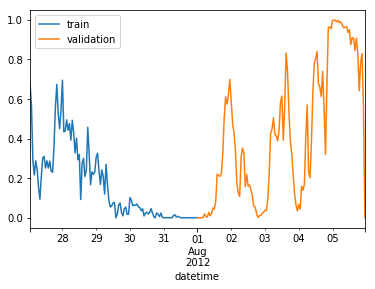

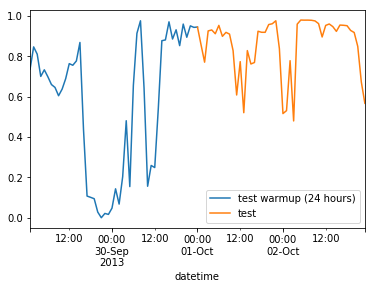

train:  (5112, 1)
validation:  (1465, 1)
warmup:  (48, 1)
xxx:  (72, 1)
test:  (48, 1)


In [3]:
train = df_merged.loc['2012-01-01':'2012-08-01 00:00:00']
dev = df_merged.loc['2012-08-01':'2012-10-01 00:00:00']
test_beg = pd.Timestamp('2013-10-01 00:00:00')
test = df_merged.loc[test_beg:test_beg+pd.Timedelta('47H')]
test_warmup = df_merged.loc[test_beg-pd.Timedelta('47H'):test_beg]
xxx = df_merged.loc[test_beg-pd.Timedelta('71H'):test_beg] # when want to visualize
print("test_warmup: ", test_warmup.shape)

(train.wf1[-120:]).plot()
(dev.wf1[:120]).plot()
plt.legend(['train', 'validation'])
plt.show()

test_warmup.wf1.plot()
test.wf1.plot()
plt.legend(['test warmup (24 hours)', 'test'])
plt.show()

# train.hist(density=True, bins=20, range=(0,1))
# plt.show()

# univariate - only the power history!
train = train.values[:,0].reshape(-1,1)
dev = dev.values[:,0].reshape(-1,1)
test_warmup = test_warmup.values[:,0].reshape(-1,1)
xxx = xxx.values[:,0].reshape(-1,1)
test = test.values[:,0].reshape(-1,1)

print("train: ", train.shape)
print("validation: ", dev.shape)
print("warmup: ", test_warmup.shape)
print("xxx: ", xxx.shape)
print("test: ", test.shape)

In [4]:
horizon=48
n_input=4
debug = False

In [5]:
def cross_validation(data, model, n_input=n_input, horizon=horizon, n_splits=20, fit=False, debug=False, title=''):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    errors = []
    y_reals = []
    y_preds = [] # probabilistic
    y_preds_median = []
    for tr_idx, te_idx in tscv.split(data):
        if len(te_idx) < horizon:
            horizon = len(te_idx)
            print("horizon clipped to %i, reduce n_splits for longer horizons!" % len(te_idx))
        X = data[tr_idx, :]
        y = data[tr_idx[-1]+1:tr_idx[-1]+1+horizon, :]
        model.fit(X, y, n_input=n_input, debug=debug) if fit else None
        ypred = model.forecast(warmup=X[-n_input:], test=y)
        y_preds.append(model.probabilisticForecast)
        y_preds_median.append(ypred)
        y_reals.append(y[:,0])
        assert len(ypred) == len(y[:,0])
        errors.append(mean_squared_error(y[:,0], ypred))
        if debug:
            plt.plot(y[:,0])
            plt.plot(ypred)
            plt.show()
    plt.figure(figsize=(6,4))
    plt.boxplot(errors)
    plt.title('%s MSE Average: %2.4f' % (title, np.mean(errors)))
    plt.show()
    return np.array(y_reals), np.array(y_preds), np.array(y_preds_median), np.array(errors)

## Baselines

### signal without noise - lower bound

This would be our prediction goal in both models. Perhaps the model that incorporates uncertainty would better/faster be able to learn!

In [6]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

# tscv = TimeSeriesSplit(n_splits=20)
# errors = []
# for tr_idx, te_idx in tscv.split(dev_sig):
#     y_nonoise = dev_sig[tr_idx[-1]+1:tr_idx[-1]+1+horizon]
#     y = dev[tr_idx[-1]+1:tr_idx[-1]+1+horizon]
#     errors.append(mean_squared_error(y, y_nonoise))
# #     plt.plot(y_nonoise)
# #     plt.plot(y)
# #     plt.show()
# plt.figure(figsize=(6,4))
# plt.boxplot(errors)
# plt.title('MSE average: %2.4f' % np.mean(errors))
# plt.show()

### Quantile Persistence

We should definitely not do any worse than this!

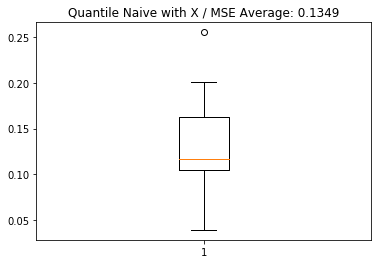

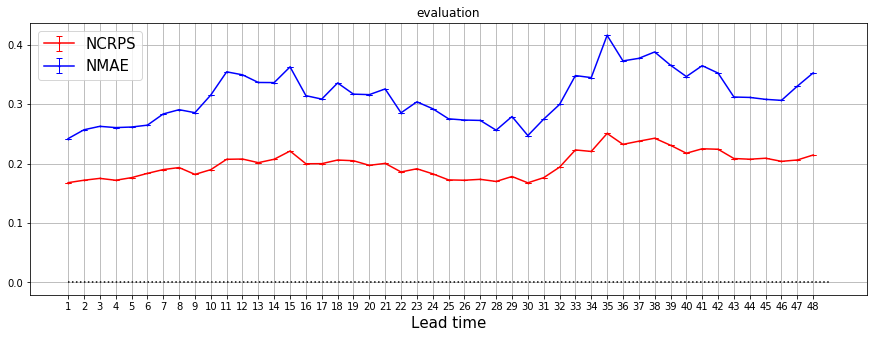

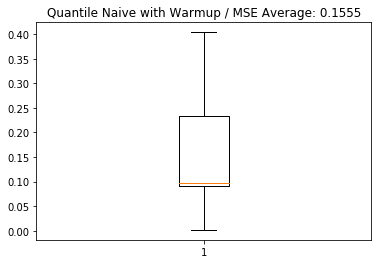

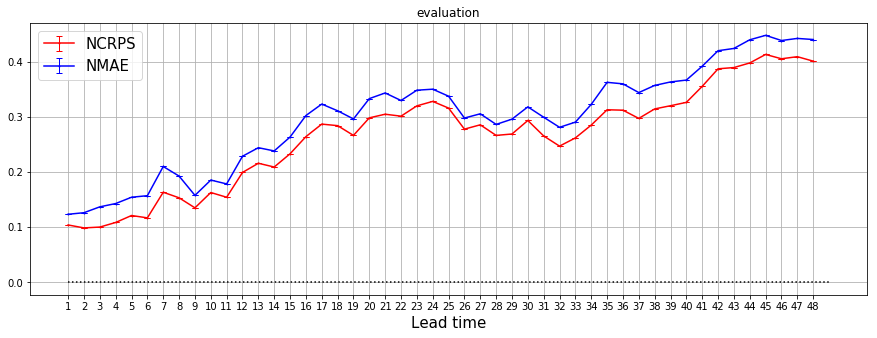

In [7]:
from baselines import naive_quantile
from probabilistic_forecast import ProbabilisticForecast
from evaluation import *
from visualization import *

class ModelBase:
    def __init__(self):
        self.probabilisticForecast = None
        
    def fit(self, X, y, n_input, debug=False):
        return
    def forecast(warmup, test, horizon):
        return
        
class QuantileNaive(ModelBase):
    def __init__(self, horizon=24, forecast_with_warmup=False):
        # for the naive we need horizon at the fit and forecast time so we set initially!
        super(ModelBase, self).__init__()
        self.horizon = horizon 
        self.probabilisticForecast = None
        self.warmupForecast = forecast_with_warmup
        
    def fit(self, X, y, **argv):
        self.probabilisticForecast = None
        if not self.warmupForecast:
            ypred_naive = naive_quantile(X, self.horizon)
            self.probabilisticForecast = ProbabilisticForecast(ypred_naive.flatten().tolist())
        
    def forecast(self, warmup, test, **argv):
        if self.warmupForecast:
            ypred_naive = naive_quantile(warmup, self.horizon)
            self.probabilisticForecast = ProbabilisticForecast(ypred_naive.flatten().tolist())
        ypred_median = self.probabilisticForecast.median()
        return ypred_median
    
    def forecast_probabilistic(self, warmup, test, **argv):
        if self.warmupForecast:
            ypred_naive = naive_quantile(warmup, self.horizon)
            self.probabilisticForecast = ProbabilisticForecast(ypred_naive.flatten().tolist())
        return self.probabilisticForecast

# Use all training data to calculate quantiles
quantileNaive = QuantileNaive(horizon=horizon, forecast_with_warmup=False)
y_real, y_preds_prob_qnaive1, \
y_preds_qnaive1, errors_qnaive_1 = cross_validation(dev, quantileNaive, 
                                                    fit=True,n_splits=12, 
                                                    horizon=horizon, title='Quantile Naive with X /')
ncrps_qnaive, nmae_qnaive = evaluate(y_real, y_preds_prob_qnaive1, period=horizon)
plot_evaluation(ncrps_qnaive, nmae_qnaive, period=horizon, title='evaluation')

# Use only the warmup to calculate quantiles
quantileNaive = QuantileNaive(horizon=horizon, forecast_with_warmup=True)
y_real, y_preds_prob_qnaive2, \
y_preds_qnaive2, errors_qnaive_2 = cross_validation(dev, quantileNaive, debug=False,
                                                    fit=True,n_splits=20, 
                                                    horizon=horizon, title='Quantile Naive with Warmup /')
ncrps_qnaive, nmae_qnaive = evaluate(y_real, y_preds_prob_qnaive2, period=horizon)
plot_evaluation(ncrps_qnaive, nmae_qnaive, period=horizon, title='evaluation')

Results obtained here could be totally opposite for another type of data. I suspect since we are having a sinusoidal the mean of the signal is not changing that much and that explains why quantile prediction over the whole data rather a part of it would give a better result. On the other hand, this observation leads to the fact that provided the trend removed from the data and even seasonality this naive method is already something.

### Persistence

In [8]:
class Naive(ModelBase):
    def forecast(self, warmup, test):
        horizon = len(test)
        return np.array([warmup[-1]] * horizon)
    
    
naive = Naive()
# y_real, _, y_preds_naive, errors_naive = cross_validation(dev.values[:,0], naive, 
#                                                             fit=False,n_splits=20, 
#                                                             horizon=horizon, title='Naive /')

# ncrps_naive, nmae_naive = evaluate_nonquantile(y_real, y_preds_naive, period=horizon)
# plot_evaluation(ncrps_naive, nmae_naive, period=horizon, title='evaluation')

Reason for how the above plot looks like what it looks like is that I fill the quantile values all with the same value of the naive prediction. nmae behavior is the direct reflection of the sinusoidal as prediction naive are closer to real values at the beginning but gradually degrades, yet since it is a sinusoidal this periodic behavior emerges in nmae which is a direct reflection of the our signal. It is not the case for ncrps behavior in ncrps we are measuring the prediction at different quantiles and the prediction is basically "more" right at one quantile (0.5) and wrong at the rest that is why ncrps behavior completely the opposite of the nmae or the true signal.

## Good Old Model

In [9]:
import tensorflow as tf
import keras
import keras.backend as K
from keras.callbacks import Callback
from keras.models import Model, Input
from keras.layers import GRU, Dense, LSTM, Dropout, TimeDistributed, LeakyReLU, BatchNormalization, Activation, Flatten
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.regularizers import l2
from clr_callback import *

np.random.seed(10)

def mapping_to_target_range( x, target_min=0, target_max=1 ) :
    x02 = K.tanh(x) + 1 # x in range(0,2)
    scale = ( target_max-target_min )/2.
    return  x02 * scale + target_min

class ModelOld(ModelBase):
    def build_model(self, n_input, n_features):
        #
        x_in = Input(shape=(n_input, n_features,))
        x = GRU(100, recurrent_dropout=0.3, return_sequences=False, input_shape=(n_input, n_features))(x_in)
        mean = Dense(1, activation='hard_sigmoid', name='mean')(x)
        model = Model(inputs=x_in, outputs=mean)
        model.compile(loss='mean_squared_error', optimizer='adam')
        print(model.summary())
        return model

    def fit(self, train, dev, n_input=24, debug=True):
        n_features = train.shape[1]
        #
        generator = TimeseriesGenerator(train, train[:,0], length=n_input)
        dev_generator = TimeseriesGenerator(dev, dev[:,0], length=n_input)
        batch_size = 32
        epoch_steps = train.shape[0]/batch_size
        #
        self.model0 = self.build_model(n_input, n_features)
        clr_cb = CyclicLR(mode='triangular2', base_lr=0.00001, max_lr=0.01, step_size=epoch_steps, gamma=0.8)
        history = self.model0.fit_generator(generator, validation_data=dev_generator, shuffle=False, 
                                      epochs=10, verbose=1, steps_per_epoch=epoch_steps, callbacks=[clr_cb])
        self.history = history
        self.n_input = n_input
        
        
    def forecast(self, warmup, test):
        n_input = self.n_input
        history = warmup[-n_input:].reshape(1,-1,test.shape[1])
        predictions = []
        ypred = self.model0.predict(history)
        predictions.append(ypred[0][0])
        #
        for h in range(len(test)-1):
            x_tp1 = np.append(predictions[-1], test[h,1:]).reshape(1,1,-1)
            history = np.append(history, x_tp1, axis=1)
            history = history[:,-n_input:,:]
            ypred = self.model0.predict(history)
            predictions.append(ypred[0][0])
        #
        predictions = np.array(predictions)
        return predictions
    
    def evaluate(self, warmup, test):
        ypred = self.forecast(warmup, test)
        ncrps, nmae = evaluate_nonquantile(test, ypred, period=lest(test))
        mse = mean_squared_error(test, ypred)
        return mse, ncrps, nmae
    
    
modelOld = ModelOld()
modelOld.fit(train, dev, n_input, debug=True)

Instructions for updating:
Colocations handled automatically by placer.


Using TensorFlow backend.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4, 1)              0         
_________________________________________________________________
gru_1 (GRU)                  (None, 100)               30600     
_________________________________________________________________
mean (Dense)                 (None, 1)                 101       
Total params: 30,701
Trainable params: 30,701
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
160/159 [==============================] - 5s 34ms/step - loss: 0.0388 - val_loss: 0.0145
Epoch 2/10
160/159 [==============================] - 5s 32ms/step - loss: 0.0086 - val_loss: 0.0106
Epoch 3/10
160/159 [============

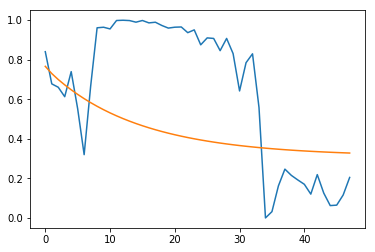

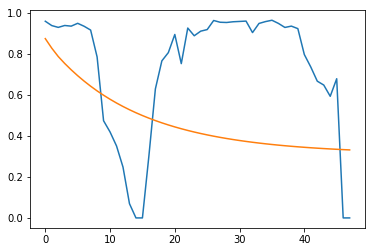

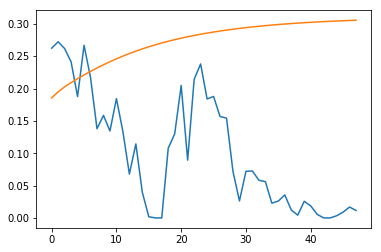

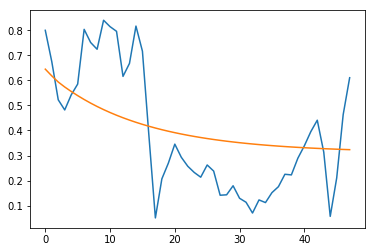

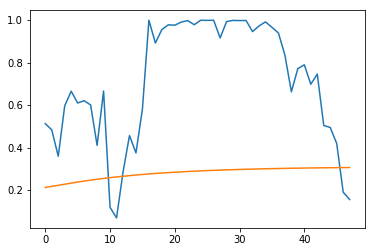

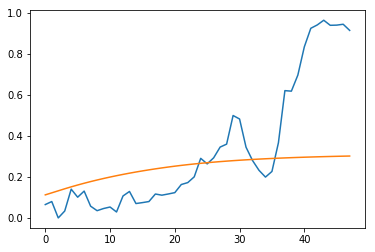

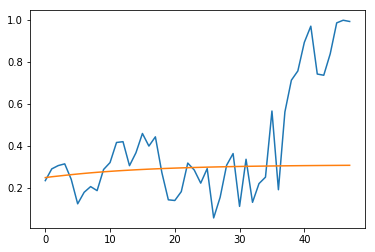

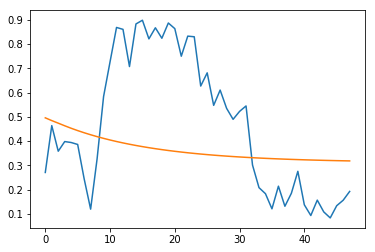

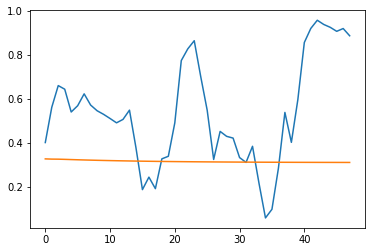

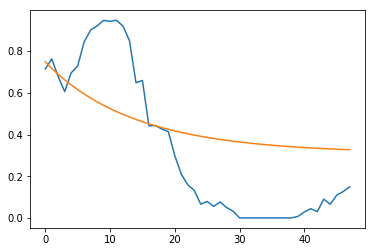

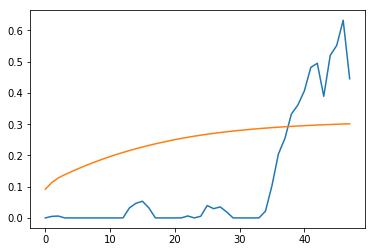

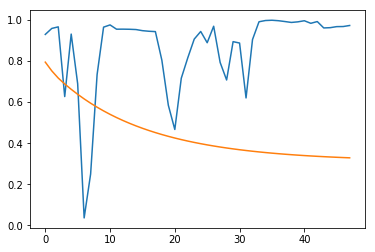

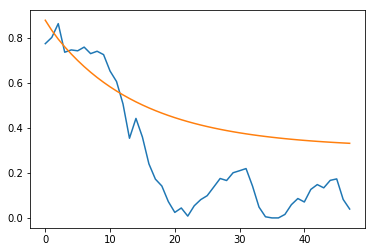

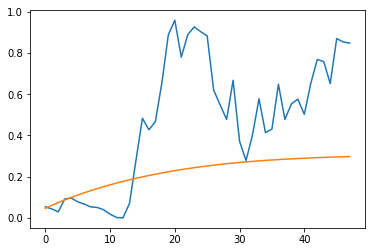

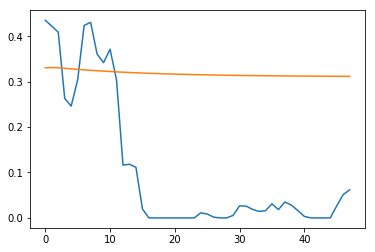

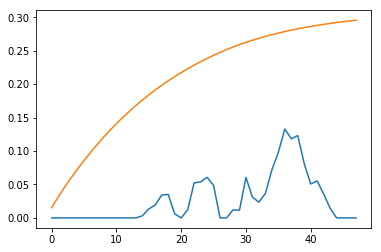

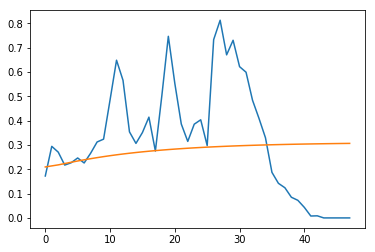

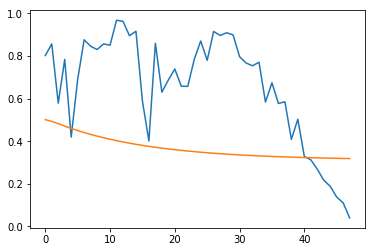

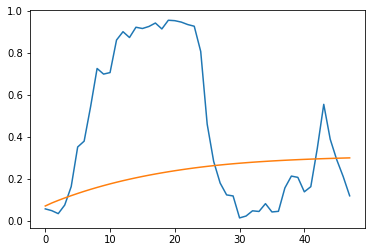

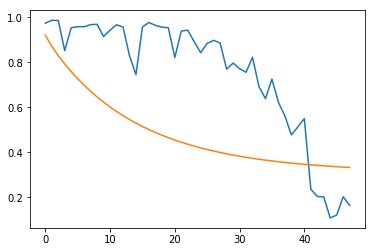

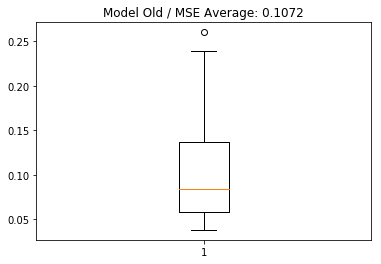

In [10]:
y_real, y_preds_oldmodel, \
y_preds_oldmodel_median, errors_oldmodel = cross_validation(dev, modelOld, debug=True,
                                                            fit=False, n_splits=20, 
                                                            horizon=horizon, title='Model Old /')

* using tanh and scaling at the final layer for the mean to keep it between 0 and 1 range (wind power)
* cyclical learning rate proved to pace up the learning and hence employed in all experiments with subtle learning rate boundaries
* network architecture, dropout rate, and other dynamics of the network remains the same for all other models as well. except for the model output for the aleatoric case(s)
* It is sufficient to run the old model and epistemic model for only < 5 epochs since after that no improvements made but for the sake of comparison all models ran for 10 epochs (as 10 epochs was the idea epochs for learning the aleatoric uncertainty!)

## Model with Aleatoric Uncertainty

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 4, 1)         0                                            
__________________________________________________________________________________________________
gru_2 (GRU)                     (None, 100)          30600       input_2[0][0]                    
__________________________________________________________________________________________________
mean (Dense)                    (None, 1)            101         gru_2[0][0]                      
__________________________________________________________________________________________________
log_var (Dense)                 (None, 1)            101         gru_2[0][0]                      
Total params: 30,802
Trainable params: 30,802
Non-trainable params: 0
_______________________________________

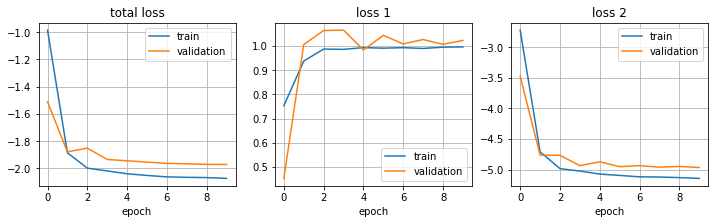

In [11]:
import tensorflow as tf
import keras
import keras.backend as K
from keras.callbacks import Callback
from keras.models import Model, Input
from keras.layers import GRU, Dense, LSTM, Dropout, TimeDistributed, LeakyReLU, BatchNormalization, Activation, Flatten
from keras.preprocessing.sequence import TimeseriesGenerator
from clr_callback import *
from visualization import *
from probabilistic_forecast import *

np.random.seed(10)

class CustomGen(TimeseriesGenerator):
    def __getitem__(self, index):
        if self.shuffle:
            rows = np.random.randint(
                self.start_index, self.end_index + 1, size=self.batch_size)
        else:
            i = self.start_index + self.batch_size * self.stride * index
            rows = np.arange(i, min(i + self.batch_size *
                                    self.stride, self.end_index + 1), self.stride)

        samples = np.array([self.data[row - self.length:row:self.sampling_rate]
                            for row in rows])
        targets = np.array([self.targets[row] for row in rows])

        if self.reverse:
            return samples[:, ::-1, ...], targets
        return samples, [targets,targets]

def mean_loss(log_var):
    def customLoss(yTrue, yPred):
        loss1 = K.mean(K.exp(-log_var) * K.square(yTrue - yPred))
        return loss1
    return customLoss

def var_loss(log_var):
    def customLoss(yTrue, yPred):
        #loss2 = K.sqrt(K.exp(log_var))
        loss2 = log_var # why this works and above doesn't?!
        return loss2
    return customLoss

class ModelAleatoric(ModelBase):
    def build_model(self, n_input, n_features):
        #
        x_in = Input(shape=(n_input, n_features,))
        x = GRU(100, recurrent_dropout=0.3, return_sequences=False, input_shape=(n_input, n_features))(x_in)
        mean = Dense(1, activation='hard_sigmoid', name='mean')(x)
        log_var = Dense(1, activation='linear', name='log_var')(x)
        model = Model(inputs=x_in, outputs=[mean, log_var])
        opt = keras.optimizers.Adam(lr=0.01)
        model.compile(loss=[mean_loss(log_var), var_loss(log_var)], loss_weights=[.5, .5], optimizer=opt)
        print(model.summary())
        return model

    def fit(self, train, dev, n_input=24, debug=False):
        n_features = train.shape[1]
        
        generator = CustomGen(train, train[:,0], length=n_input)
        dev_generator = CustomGen(dev, dev[:,0], length=n_input)
        batch_size = 32
        epoch_steps = train.shape[0]/batch_size

        self.model_al = self.build_model(n_input, n_features)
        clr_cb = CyclicLR(mode='triangular2', base_lr=0.00001, max_lr=0.01, step_size=epoch_steps, gamma=0.8)


        self.history = self.model_al.fit_generator(generator, validation_data=dev_generator, shuffle=False, 
                                      epochs=10, verbose=1, steps_per_epoch=epoch_steps, callbacks=[clr_cb])
        self.n_input = n_input
        if debug:
            plot_learning_curve(self.history)
            
    def forecast(self, warmup, test):
        n_input = self.n_input
        history = warmup[-n_input:].reshape(1,-1,test.shape[1])
        # history = test_warmup[np.newaxis,-n_input:,:]# generator[-1][0][-1][np.newaxis,:,:]
        # print(history[:,-2:,:])
        predictions = []
        predictions_logvar = []
        ypred = self.model_al.predict(history)
        predictions.append(ypred[0][0][0])
        predictions_logvar.append(ypred[1][0][0])
    
        for h in range(len(test)-1):
            x_tp1 = np.append(predictions[-1], test[h,1:]).reshape(1,1,-1)
            history = np.append(history, x_tp1, axis=1)
            history = history[:,-n_input:,:]
            ypred = self.model_al.predict(history)
            predictions.append(ypred[0][0][0])
            predictions_logvar.append(ypred[1][0][0])

        predictions = np.array(predictions)
        predictions_std = np.sqrt(np.exp(predictions_logvar))
        #return predictions, predictions_std
        #
        probabilisticForecast = ProbabilisticForecast()
        lts_all = [LeadTimeScenarios() for _ in range(len(test))]
        for h in range(len(test)):
            lts_all[h].add_scenario(Scenario(predictions[h], predictions_std[h]))
        for lts in lts_all:
            probabilisticForecast.add_variable(lts.scenarios, False) 
        return probabilisticForecast
        
modelAleatoric = ModelAleatoric()
modelAleatoric.fit(train, dev, n_input=n_input, debug=True)

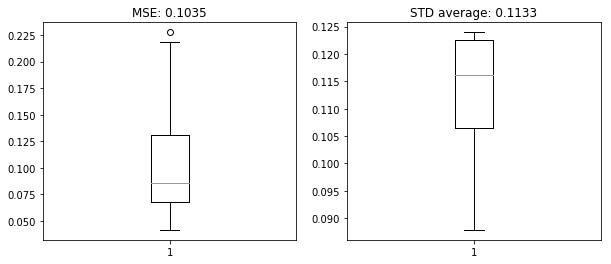

In [12]:
tscv = TimeSeriesSplit(n_splits=20)
errors_al = []
stds_al = []
for tr_idx, te_idx in tscv.split(dev):
    X = dev[tr_idx,:]
    y = dev[tr_idx[-1]+1:tr_idx[-1]+1+horizon,:]
    ypred = modelAleatoric.forecast(warmup=X[-n_input:], test=y)
    stds_al.append(np.mean(ypred.std()))
    y = y[:,0]
    errors_al.append(mean_squared_error(y, ypred.median()))
    if debug:
        plt.plot(X[-72:,0])
        plt.plot(range(len(X[-72:]), len(X[-72:])+len(y)), y)
        plt.plot(range(len(X[-72:]), len(X[-72:])+len(y)), ypred.median())
        plt.fill_between(range(len(X[-72:]), len(X[-72:])+len(y)), ypred.median()-ypred.std(), ypred.median()+ypred.std(), color='orange', alpha=0.25)
        plt.title('mse: %2.3f  avg_std: %2.3f' % (errors_al[-1], np.mean(ypred.std())))
        plt.show()
        
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.boxplot(errors_al)
plt.title('MSE: %2.4f' % np.mean(errors_al))
#
plt.subplot(1,2,2)
plt.boxplot(stds_al)
plt.title('STD average: %2.4f' % np.mean(stds_al))
plt.show()

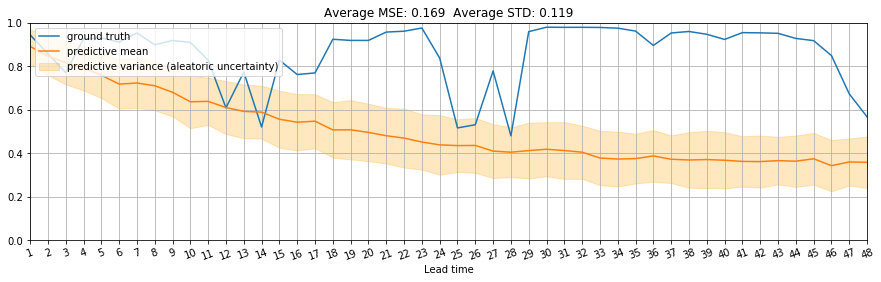

In [13]:
# on test data 
# test_warmup = test_warmup.values#samples_normalized[-(n_input+test_size):][:n_input]
predictions = modelAleatoric.forecast(test_warmup, test[:horizon])
yh_median = predictions.median()[:horizon]
yh_std = predictions.std()[:horizon]
plt.figure(figsize=(15,4))
plt.plot(test[:horizon,0], label='ground truth')
plt.plot(yh_median, label='predictive mean')
plt.fill_between(range(horizon), yh_median-yh_std, yh_median+yh_std, 
                 color='orange', alpha=0.25, label='predictive variance (aleatoric uncertainty)')
# plt.plot(dev_sig[-horizon:], label='without noise')
plt.title("Average MSE: %2.3f  Average STD: %2.3f" % 
          (mean_squared_error(test[:horizon,0], yh_median), np.mean(yh_std) ))
plt.ylim([0,1])
plt.xlim([0,horizon-1])
plt.xticks(np.arange(0, horizon), np.arange(1,horizon+1), rotation=20)
plt.legend(loc='upper left')
plt.xlabel('Lead time')
plt.grid()
plt.show()

## Model with Epistemic Uncertainty

In [14]:
import tensorflow as tf
import keras
import keras.backend as K
from keras.callbacks import Callback
from keras.models import Model, Input
from keras.layers import GRU, Dense, LSTM, Dropout, TimeDistributed, LeakyReLU, BatchNormalization, Activation, Flatten
from keras.preprocessing.sequence import TimeseriesGenerator
from clr_callback import *

np.random.seed(10)

class ModelEpistemic(ModelBase):
    def build_model(self, n_input, n_features):
        #
        x_in = Input(shape=(n_input, n_features,))
        x = GRU(100, recurrent_dropout=0.3, return_sequences=False, input_shape=(n_input, n_features))(x_in, training=True)
        mean = Dense(1, activation='hard_sigmoid', name='mean')(x)
        model = Model(inputs=x_in, outputs=mean)
        model.compile(loss='mean_squared_error', optimizer='adam')
        print(model.summary())
        return model

    def fit(self, train, dev, n_input=24, debug=False):
        n_features = train.shape[1]

        generator = TimeseriesGenerator(train, train[:,0], length=n_input)
        dev_generator = TimeseriesGenerator(dev, dev[:,0], length=n_input)
        batch_size = 32
        epoch_steps = train.shape[0]/batch_size

        self.model_ep = self.build_model(n_input, n_features)
        clr_cb = CyclicLR(mode='triangular2', base_lr=0.00001, max_lr=0.01, step_size=epoch_steps, gamma=0.8)
        self.history = self.model_ep.fit_generator(generator, validation_data=dev_generator, shuffle=False, 
                                         epochs=10, verbose=1, steps_per_epoch=epoch_steps, callbacks=[clr_cb])
        self.n_input = n_input
        
    
    def forecast(self, warmup, test, nc_simulation=10):
        n_input = self.n_input
        def neuralnet_prediction(warmup, test):
            history = warmup.reshape(1,-1,test.shape[1])
            predictions = []
            ypred = self.model_ep.predict(history)
            predictions.append(ypred[0][0])
            #
            for h in range(len(test)-1):
                x_tp1 = np.append(predictions[-1], test[h,1:]).reshape(1,1,-1)
                history = np.append(history, x_tp1, axis=1)
                history = history[:,-n_input:,:]
                ypred = self.model_ep.predict(history)
                predictions.append(ypred[0][0])
            #
            predictions = np.array(predictions)
            return predictions
        #
        horizon = len(test)
        mc_preds = np.empty((0,horizon))
        for i in range(nc_simulation): # parallelize this part of the code
            ypred = neuralnet_prediction(warmup, test[:horizon])
            mc_preds = np.append(mc_preds, ypred.reshape(1,-1), axis=0)
        #
        #return np.median(mc_preds, axis=0), np.std(mc_preds, axis=0)
        probabilisticForecast = ProbabilisticForecast()
        lts_all = [LeadTimeScenarios() for _ in range(len(test))]
        for i in range(nc_simulation):
            for h in range(len(test)):
                lts_all[h].add_scenario(Scenario(np.mean(mc_preds, axis=0)[h], np.std(mc_preds, axis=0)[h]))
        for lts in lts_all:
            probabilisticForecast.add_variable(lts.scenarios, False) 
        return probabilisticForecast
    

modelEpistemic = ModelEpistemic()
modelEpistemic.fit(train, dev, n_input=n_input, debug=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 4, 1)              0         
_________________________________________________________________
gru_3 (GRU)                  (None, 100)               30600     
_________________________________________________________________
mean (Dense)                 (None, 1)                 101       
Total params: 30,701
Trainable params: 30,701
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
160/159 [==============================] - 11s 72ms/step - loss: 0.0388 - val_loss: 0.0146
Epoch 2/10
160/159 [==============================] - 8s 48ms/step - loss: 0.0086 - val_loss: 0.0106
Epoch 3/10
160/159 [==============================] - 7s 41ms/step - loss: 0.0081 - val_loss: 0.0107
Epoch 4/10
160/159 [==============================] - 6s 38ms/step - loss: 0.0081 - val_loss:

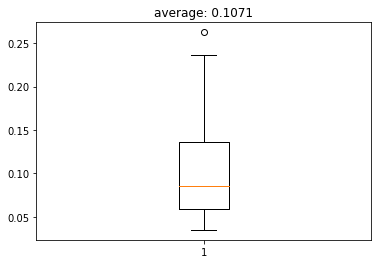

In [15]:
from tqdm import tqdm_notebook as tqdm

tscv = TimeSeriesSplit(n_splits=20)
errors_ep = []
for tr_idx, te_idx in tqdm(tscv.split(dev), total=20):
    X = dev[tr_idx,:]
    y = dev[tr_idx[-1]+1:tr_idx[-1]+1+horizon,:]
    ypred = modelEpistemic.forecast(warmup=X[-n_input:], test=y, nc_simulation=20)
    errors_ep.append(mean_squared_error(y[:,0], ypred.median()))
    if debug:
        plt.plot(y[:,0])
        plt.plot(ypred.median())
        plt.show()
plt.figure(figsize=(6,4))
plt.boxplot(errors_ep)
plt.title('average: %2.4f' % np.mean(errors_ep))
plt.show()

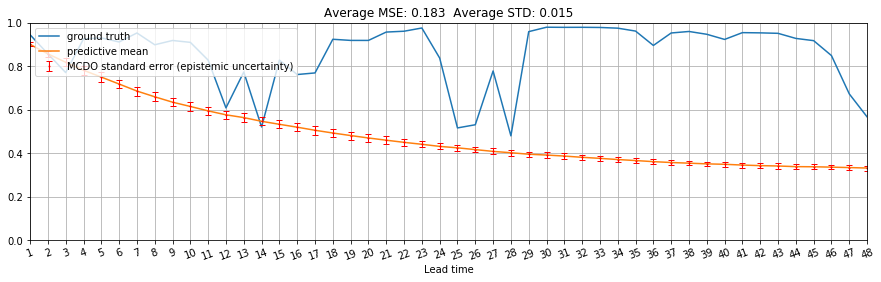

In [16]:
plt.rcParams['figure.figsize'] = [15, 4]

# test_warmup = test_warmup#samples_normalized[-(n_input+test_size):][:n_input]
ypred = modelEpistemic.forecast(test_warmup[-n_input:], test[:horizon], 20)
yh_median = ypred.median()
yerr = ypred.std()
plt.plot(test[:horizon,0], label='ground truth')
plt.plot(yh_median[:horizon], label='predictive mean')
plt.errorbar(range(horizon), yh_median[:horizon], yerr=yerr[:horizon], 
             color='red', fmt='o', capsize=3, label='MCDO standard error (epistemic uncertainty)', markersize=1, elinewidth=1)
# plt.fill_between(range(len(test)), predictions-predictions_std, 
#                  predictions+predictions_std, color='orange', alpha=0.25, label='PI (aleatoric)')
# plt.plot(dev_sig[-n_input:], label='without noise')
plt.title("Average MSE: %2.3f  Average STD: %2.3f" % 
          (mean_squared_error(test[:horizon,0], yh_median[:horizon]), np.mean(yerr))[:horizon] )
plt.ylim([0,1])
plt.xlim([0,horizon-1])
plt.xticks(np.arange(0, horizon), np.arange(1,horizon+1), rotation=20)
plt.legend(loc='upper left')
plt.xlabel('Lead time')
plt.grid()
plt.show()

## Model with Aleatoric + Epistemic Uncertainties

In [17]:
import tensorflow as tf
import keras
import keras.backend as K
from keras.callbacks import Callback
from keras.models import Model, Input
from keras.layers import GRU, Dense, LSTM, Dropout, TimeDistributed, LeakyReLU, BatchNormalization, Activation, Flatten
from keras.preprocessing.sequence import TimeseriesGenerator
from clr_callback import *
from probabilistic_forecast import *

np.random.seed(10)

class ModelAleatoricEpistemic(ModelBase):
    
    def build_model(self, n_input, n_features):
        #
        x_in = Input(shape=(n_input, n_features,))
        x = GRU(100, recurrent_dropout=0.3, return_sequences=False, input_shape=(n_input, n_features))(x_in, training=True)
        mean = Dense(1, activation='hard_sigmoid', name='mean')(x)
        log_var = Dense(1, activation='linear', name='log_var')(x)
        model = Model(inputs=x_in, outputs=[mean, log_var])
        opt = keras.optimizers.Adam(lr=0.01)
        model.compile(loss=[mean_loss(log_var), var_loss(log_var)], loss_weights=[.5, .5], optimizer=opt)
        print(model.summary())
        return model

    def fit(self, train, dev, n_input=24):
        n_features = train.shape[1]

        generator = CustomGen(train, train[:,0], length=n_input)
        dev_generator = CustomGen(dev, dev[:,0], length=n_input)
        batch_size = 32
        epoch_steps = train.shape[0]/batch_size

        self.model_alep = self.build_model(n_input, n_features)
        clr_cb = CyclicLR(mode='triangular2', base_lr=0.00001, max_lr=0.01, step_size=epoch_steps, gamma=0.8)
        self.history = self.model_alep.fit_generator(generator, validation_data=dev_generator, shuffle=False, 
                                      epochs=10, verbose=1, steps_per_epoch=epoch_steps, callbacks=[clr_cb])
        if debug:
            plot_learning_curve(self.history)
        self.n_input = n_input
            
    def forecast(self, warmup, test, nr_simulations=10):
        n_input = self.n_input
        yhats = np.empty((0,len(test)))
        yhats_std = np.empty((0,len(test)))
        for i in range(nr_simulations):
            history = warmup.reshape(1,-1,test.shape[1])
            predictions = []
            predictions_logvar = []
            ypred = self.model_alep.predict(history)
            predictions.append(ypred[0][0][0])
            predictions_logvar.append(ypred[1][0][0])
            for h in range(len(test)-1):
                x_tp1 = np.append(predictions[-1], test[h,1:]).reshape(1,1,-1)
                history = np.append(history, x_tp1, axis=1)
                history = history[:,-n_input:,:]
                ypred = self.model_alep.predict(history)
                predictions.append(ypred[0][0][0])
                predictions_logvar.append(ypred[1][0][0])
            yhats = np.append(yhats, np.array(predictions).reshape(1,-1), axis=0)
            yhats_std = np.append(yhats_std, np.sqrt(np.exp(predictions_logvar)).reshape(1,-1), axis=0)
        # 
        probabilisticForecast = ProbabilisticForecast()
        lts_all = [LeadTimeScenarios() for _ in range(len(test))]
        for i in range(nr_simulations):
            for h in range(len(test)):
                lts_all[h].add_scenario(Scenario(yhats[i,h], yhats_std[i,h]))
        for lts in lts_all:
            probabilisticForecast.add_variable(lts.scenarios, False) 
        return probabilisticForecast
    
    def scenario_forecast(self, test_warmup, test, horizon=24, n_sims=15):
        n_input = self.n_input
        def neuralnet_scenario_forecasting(warmup, test, nr_simulations=1, debug=False):
            #yhats = np.empty((0,len(test)))
            #yhats_std = np.empty((0,len(test)))
            mcSimulation = MCSimulation(nr_simulations=nr_simulations)
            for i in tqdm(range(nr_simulations), desc="MCDO Simulation"):
        #         print(i)
                # Start a trajectory by warmup sequence and then generate new 
                # alternative futures or aka scenarios based on new predictions
                history = warmup.reshape(1,-1,test.shape[1])
                trajectory = Trajectory(history=history, debug=debug)
                # first lead time prediction, first scenario (only one) 
                # TODO: could be more than only one, by running prediction multiple times (MCDO)
                lts = LeadTimeScenarios() # create new lead time scenarios
                for _ in range(10):
                    pred = self.model_alep.predict(history) ########################################
                    mu, sigma = pred_to_musigma(pred) # get the predicted mu and sigma
                    lts.add_scenario(Scenario(mu, sigma)) # create new scenario
                trajectory.add_leadtime(lts) # add current scenario to the trajectory
                #
                for h in range(1,len(test)): # roll forward
                    # generate histories based on previous LTS
                    histories = trajectory.generate_histories(n_input=n_input, n_samples=3, test=test[h,1:]) 
                    lts = LeadTimeScenarios() # create new lead time scenario(s)
                    # traverse possible histories and predict one-step ahead which 
                    # leads to traversing possible futures basically
                    for history in histories:
                        pred = self.model_alep.predict(history) ################################
                        mu, sigma = pred_to_musigma(pred)
                        lts.add_scenario(Scenario(mu, sigma)) # create new scenario
                    # Dropping some of the scenarios to avoid explosion of alternative futures
                    #lts.drop_randomly(probability=0.5)
                    trajectory.add_leadtime(lts)
                mcSimulation.add_trajectory(trajectory)
                #yhats = np.append(yhats, np.array(predictions).reshape(1,-1), axis=0)
                #yhats_std = np.append(yhats_std, np.sqrt(np.exp(predictions_logvar)).reshape(1,-1), axis=0)
            return mcSimulation
        
        # make prediction
        self.mcSimulation = neuralnet_scenario_forecasting(test_warmup, test[:horizon], n_sims, debug=True)

        def mcSimulation_to_probabilisticForecast(mcSimul, test):
            # print(len(mcSimulation.trajectories))
            # print(len(mcSimulation.trajectories[9].leadTimeScenarios))
            # print(len(mcSimulation.trajectories[9].leadTimeScenarios[71].scenarios))
            probForecast = ProbabilisticForecast()
            assert n_sims == len(mcSimul.trajectories)
            #
            # aggregate results of MCDO and scenario forecasts: 
            # we have a number of mu and sigmas per leadtime now (needs to be aggregated)
            lts_all = [LeadTimeScenarios() for _ in range(len(test))] # aggregate all possible scenarios per time step
            for i in tqdm(range(n_sims), desc='MCDO+ScenarioForecasting'): # scenarios per lead time (aka leadtime scenarios) as a result of mcdo simulation
                for h, lts in enumerate(mcSimul.trajectories[i].leadTimeScenarios): # scenarios from scenario forecasting
                    for s in lts.scenarios:
                        lts_all[h].add_scenario(s)
            #
            for lts in tqdm(lts_all, desc='LTS to RV'): # create random variable for easier evaluation and visualization
                probForecast.add_variable(lts.scenarios, False)    
            return probForecast

        probabilisticForecast = mcSimulation_to_probabilisticForecast(self.mcSimulation, test[:horizon])
        return probabilisticForecast

modelAleatoricEpistemic = ModelAleatoricEpistemic()
modelAleatoricEpistemic.fit(train, dev, n_input=n_input)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 4, 1)         0                                            
__________________________________________________________________________________________________
gru_4 (GRU)                     (None, 100)          30600       input_4[0][0]                    
__________________________________________________________________________________________________
mean (Dense)                    (None, 1)            101         gru_4[0][0]                      
__________________________________________________________________________________________________
log_var (Dense)                 (None, 1)            101         gru_4[0][0]                      
Total params: 30,802
Trainable params: 30,802
Non-trainable params: 0
_______________________________________

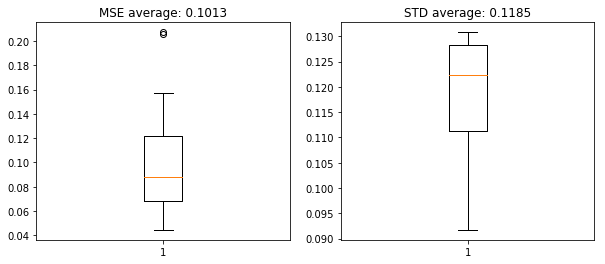

In [18]:
# expanding window validation
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
plt.rcParams['figure.figsize'] = [10, 3]

n_splits=20
tscv = TimeSeriesSplit(n_splits=n_splits)
errors_alep = []
stds_alep = []
yreal_dev = [] # for final evaluation
i=1
for tr_idx, te_idx in tqdm(tscv.split(dev), total=n_splits):
    X = dev[tr_idx,:]
    y = dev[tr_idx[-1]+1:tr_idx[-1]+1+horizon,:]
    yhat = modelAleatoricEpistemic.forecast(warmup=X[-n_input:], test=y, nr_simulations=20)
    # visualize
    if debug:
        plot_forecast_dense(X[-horizon:,0], y[:,0], yhat, horizon=horizon, alphas=[0.05, 0.15, 0.25, 0.35, 0.5])
        #plot_vis1(yhat.median(), yhat.std(), y, expressive=False)
        #plot_vis2(yhat.median(), yhat.std(), y, expressive=False)
        pass
    #
    stds_alep.append(np.mean(yhat.std()))
    errors_alep.append(mean_squared_error(y[:,0], yhat.median()))
    yreal_dev.append(y)
    #print("%i -> %2.3f" % (i, errors[-1]))
    #i+=1
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.boxplot(errors_alep)
plt.title('MSE average: %2.4f' % np.mean(errors_alep))
#
plt.subplot(1,2,2)
plt.boxplot(stds_alep)
plt.title('STD average: %2.4f' % np.mean(stds_alep))
plt.show()

## MCDO forecasting

In [19]:
test.shape

(48, 1)

48


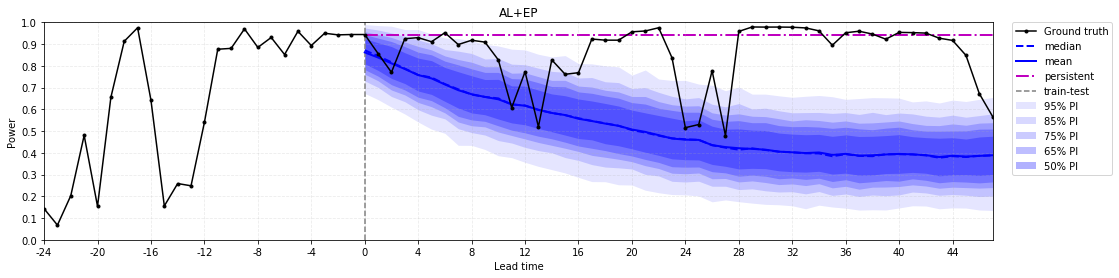

In [20]:
from baselines import naive
from calibration_curves import *

# On test data
plt.rcParams['figure.figsize'] = [17, 6]
# on test data
# test_warmup = test_warmup#samples_normalized[-(n_input+test_size):][:n_input]
# make prediction
yhat = modelAleatoricEpistemic.forecast(warmup=test_warmup[-n_input:], test=test[:horizon], nr_simulations=10)

# visualize
baselines = {'persistent': naive(xxx[:,0], horizon)}
plot_forecast_dense(xxx[:,0], test[:horizon, 0], yhat, horizon=horizon, 
                    baselines=baselines, alphas=[0.05, 0.15, 0.25, 0.35, 0.5], title='AL+EP')
# plot_calibration_curve_single_measurement(yhat, test)
# plot_vis1(yhat.median(), yhat.std(), test[:horizon], expressive=True)
# plot_vis2(yhat.median(), yhat.std(), test[:horizon], expressive=True)

## MCDO + Senario forecasting

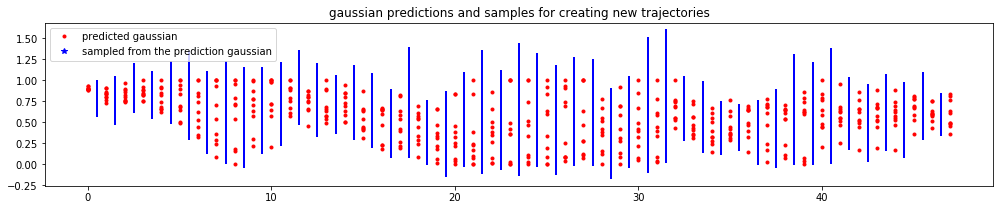

48


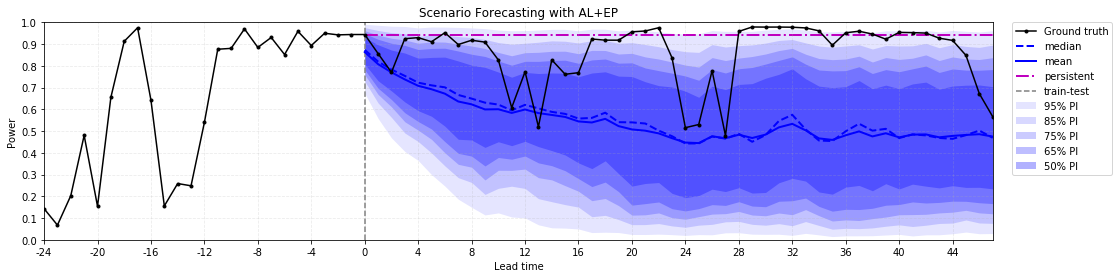

In [21]:
%matplotlib inline 
from baselines import *
from visualization import *


# on test data
# test_warmup = test_warmup#samples_normalized[-(n_input+test_size):][:n_input]
probabilisticForecast = modelAleatoricEpistemic.scenario_forecast(test_warmup[-n_input:,:], test=test, horizon=horizon, n_sims=15)

plot_mcSims(modelAleatoricEpistemic.mcSimulation, horizon) # for debug and demonstration
baselines = {'persistent': naive(xxx[:,0], horizon)}
plot_forecast_dense(xxx[-horizon:,0], test[:horizon,0], probabilisticForecast, horizon=horizon, 
                    baselines=baselines, alphas=[0.05, 0.15, 0.25, 0.35, 0.5], title='Scenario Forecasting with AL+EP')
# plot_calibration_curve_single_measurement(probabilisticForecast, test)

- the first (on the top) figure shows how scenarios being made (unfornately failed to show the trajectories for the moment). 
- The red dots output of the network and blue dots basically next samples used as the last entry for the input of the network in the next lead time (basically what creates new trajectories)

## For Thesis Text (to be cleaned up later!)

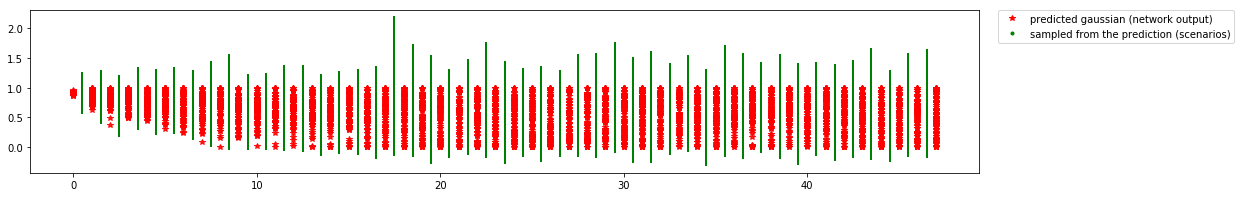

In [22]:
# Trajectories
plt.figure(figsize=(17,3))
ax = plt.axes()
for j in tqdm(range(10)):
    for h in range(horizon):
        for sc in modelAleatoricEpistemic.mcSimulation.trajectories[j].leadTimeScenarios[h].scenarios:
            ax.plot(h, sc.mu, 'r*', alpha=0.9)
            if h != horizon-1:
                #print(mcSimulation.trajectories[0].histories_track[h])
                samples = modelAleatoricEpistemic.mcSimulation.trajectories[j].histories_track[h]
                nr_samples = len(samples)
                ax.plot([h+0.5]*nr_samples, samples, 'g', alpha=0.9)
                #for history in mcSimulation.trajectories[0].histories_track[h]:
                #    ax.arrow(h, sc.mu, h+0.5, history, color='b')
ax.plot([],[], 'r*', label='predicted gaussian (network output)')            
ax.plot([],[], 'g.', label='sampled from the prediction (scenarios)')
# plt.title('gaussian predictions and samples for creating new trajectories')
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.show()

(10, 48)


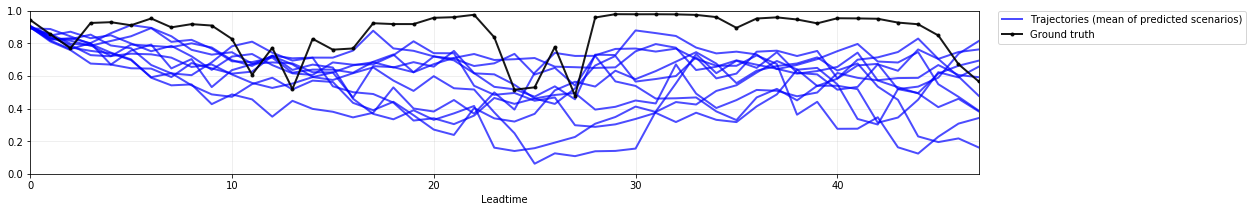

In [23]:
trajs_means = []
for j in range(10):
    means = []
    for i in range(48):
        means.append(np.mean([m.mu for m in modelAleatoricEpistemic.mcSimulation.trajectories[j].leadTimeScenarios[i].scenarios]))
    trajs_means.append(means)
trajs_means = np.array(trajs_means)
print(trajs_means.shape)
plt.figure(figsize=(17,3))
plt.plot(trajs_means.T, color='blue', linewidth=2, alpha=0.7)
plt.plot([], color='blue', linewidth=2, alpha=0.7, label='Trajectories (mean of predicted scenarios)')
# plt.plot(np.arange(-horizon//2, len(test[:horizon])), np.append(xxx.values[-horizon//2:,0], test[:horizon]), 'k.-', linewidth=2, alpha=0.9, label='Ground truth')
plt.plot(test[:horizon,0], 'k.-', linewidth=2, alpha=0.9, label='Ground truth')
plt.ylim([0,1])
# plt.xticks(range(0,48), range(-12,49))
plt.xlim([0,47])
plt.xlabel('Leadtime')
plt.grid(alpha=0.25)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.show()

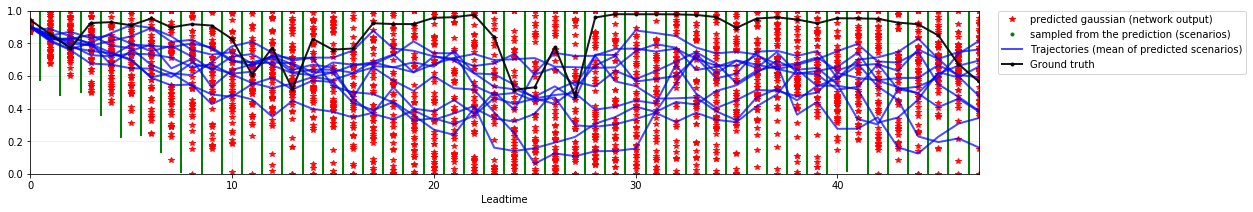

In [24]:
# Trajectories
plt.figure(figsize=(17,3))
ax = plt.axes()
for j in tqdm(range(5)):
    for h in range(horizon):
        for sc in modelAleatoricEpistemic.mcSimulation.trajectories[j].leadTimeScenarios[h].scenarios:
            ax.plot(h, sc.mu, 'r*', alpha=0.9)
            if h != horizon-1:
                #print(mcSimulation.trajectories[0].histories_track[h])
                samples = modelAleatoricEpistemic.mcSimulation.trajectories[j].histories_track[h]
                nr_samples = len(samples)
                ax.plot([h+0.5]*nr_samples, samples, 'g', alpha=0.9)
                #for history in mcSimulation.trajectories[0].histories_track[h]:
                #    ax.arrow(h, sc.mu, h+0.5, history, color='b')
ax.plot([],[], 'r*', label='predicted gaussian (network output)')            
ax.plot([],[], 'g.', label='sampled from the prediction (scenarios)')
# plt.title('gaussian predictions and samples for creating new trajectories')

trajs_means = []
for j in range(10):
    means = []
    for i in range(48):
        means.append(np.mean([m.mu for m in modelAleatoricEpistemic.mcSimulation.trajectories[j].leadTimeScenarios[i].scenarios]))
    trajs_means.append(means)
trajs_means = np.array(trajs_means)
# plt.figure(figsize=(17,3))
ax.plot(trajs_means.T, color='blue', linewidth=2, alpha=0.7)
ax.plot([], color='blue', linewidth=2, alpha=0.7, label='Trajectories (mean of predicted scenarios)')
# ax.plot(np.arange(-horizon//2, len(test[:horizon])), np.append(test_warmup[-horizon//2:], test[:horizon]), 'k.-', linewidth=2, alpha=0.9, label='Ground truth')
plt.plot(test[:horizon,0], 'k.-', linewidth=2, alpha=0.9, label='Ground truth')
plt.ylim([0,1])
# plt.xticks(range(0,48), range(-12,49))
plt.xlim([0,47])
plt.xlabel('Leadtime')
plt.grid(alpha=0.25)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.show()

48


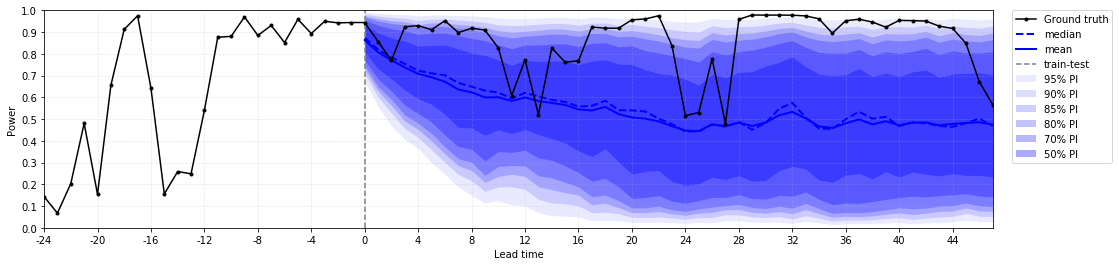

In [25]:
from visualization import plot_forecast_dense
plot_forecast_dense(xxx[:,0], test[:horizon,0], probabilisticForecast, 
                       horizon=horizon, alphas=[0.05, 0.1, 0.15, 0.2, 0.3, 0.5], title='')

## Evaluate the performance

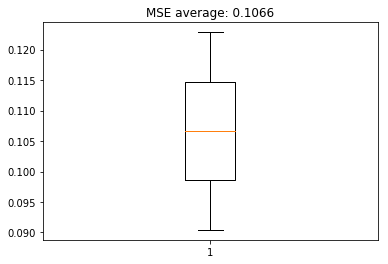

In [26]:
# expanding window cross-validation
plt.rcParams['figure.figsize'] = [10, 3]

n_sims = 2
tscv = TimeSeriesSplit(n_splits=2)
errors_alep2 = [] # errors of the mcsimulation with scenario forecasting
yreal_dev = [] # for final evaluation
i=1
ypreds_probabilistic = [] 
for tr_idx, te_idx in tscv.split(dev):
    X = dev[tr_idx,:]
    y = dev[tr_idx[-1]+1:tr_idx[-1]+1+horizon,:]
    #
    warmup = X[-n_input:]
    pforecast = modelAleatoricEpistemic.scenario_forecast(warmup, test=y, horizon=horizon, n_sims=n_sims)
    ypreds_probabilistic.append(pforecast)
    # visualize
    #baselines = {'persistent': naive(warmup, horizon)}
    #plot_forecast_dense(warmup, y, probabilisticForecast, horizon=horizon, 
    #                baselines=baselines, alphas=[0.05, 0.15, 0.25, 0.35, 0.5])
    errors_alep2.append(mean_squared_error(y[:,0], pforecast.median()))
    yreal_dev.append(y[:,0])
    #print("%i -> %2.3f" % (i, errors[-1]))
    #i+=1
plt.figure(figsize=(6,4))
plt.boxplot(errors_alep2)
plt.title('MSE average: %2.4f' % np.mean(errors_alep2))
plt.show()
#

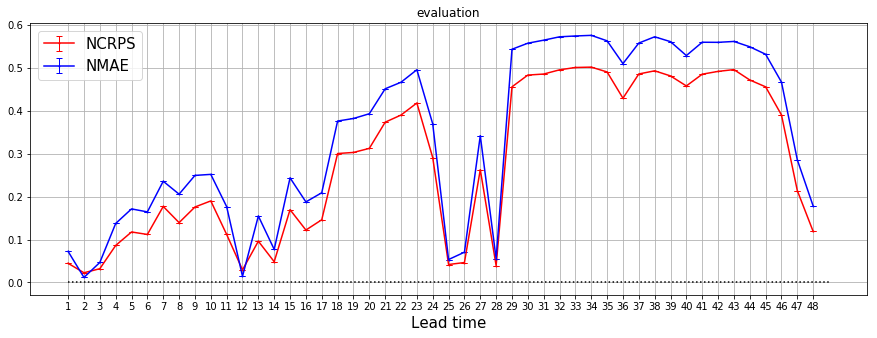

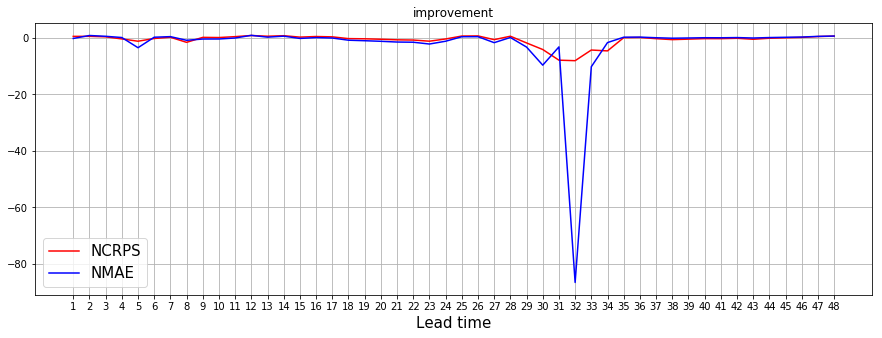

In [27]:
horizon_ = horizon
# yhat.forecast_variables = yhat.forecast_variables[:horizon_]
ncrps, nmae = evaluate(test[:horizon_, 0].reshape(1,-1,1), [yhat], period=horizon_)
plot_evaluation(ncrps, nmae, period=horizon_, title='evaluation')
# improvement
ncrps_improv = improvement(ncrps_qnaive[0,:horizon_,:][np.newaxis,::], ncrps)
nmae_improv = improvement(nmae_qnaive[0,:horizon_,:][np.newaxis,::], nmae)
plot_evaluation_2(ncrps_improv, nmae_improv, period=horizon_, title='improvement')

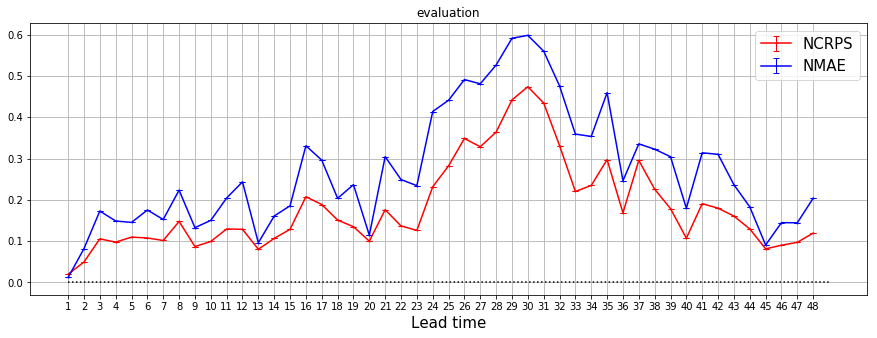

In [28]:
from evaluation import evaluate, improvement
from visualization import plot_evaluation
from visualization import plot_evaluation_2

ncrps, nmae = evaluate(np.array(yreal_dev), np.array(ypreds_probabilistic), period=horizon)
plot_evaluation(ncrps, nmae, period=horizon, title='evaluation')
# improvement
# ncrps_improv = improvement(ncrps_qnaive, ncrps)
# nmae_improv = improvement(nmae_qnaive, nmae)
# plot_evaluation_2(ncrps_improv, nmae_improv, period=horizon, title='improvement')


## Calibration curve

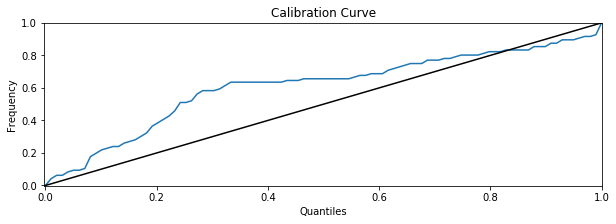

In [29]:
from calibration_curves import *
# plot_calibration_curve_single_measurement(ypreds_probabilistic[-1], yreal_dev[-1], debug=False)
plot_calibration_curve_multiple_measurements(ypreds_probabilistic, yreal_dev, debug=False)

# Results all together

In [30]:
import time 
# expanding window cross-validation
plt.rcParams['figure.figsize'] = [10, 3]

horizon = 48
n_sims = 20
n_splits = 20
tscv = TimeSeriesSplit(n_splits=n_splits)
methods = ['naive', 'qnaiveW', 'qnaiveX', 'old', 'al', 'ep', 'alep', 'sfalep']
mse = {m:[] for m in methods}
nmae = {m:[] for m in methods}
ncrps = {m:[] for m in methods}
forecasts = {m:[] for m in methods}
forecast_time = {m:[] for m in methods}
y_real = []

for tr_idx, te_idx in tqdm(tscv.split(dev), total=n_splits):
    X = dev[tr_idx,:]
    y = dev[tr_idx[-1]+1:tr_idx[-1]+1+horizon,:]
#     y_nonoise = dev_sig[tr_idx[-1]+1:tr_idx[-1]+1+horizon]
    y_real.append(y[:,0])
    
    # no noise signal
#     start = time.time()
#     mse['nonoise'].append(mean_squared_error(y, y_nonoise))
#     forecast_time['nonoise'].append(time.time()-start)
    
    # naive
    start = time.time()
    naive = Naive()
    y_naive = naive.forecast(warmup=X[-n_input:,0], test=y[:,0])
    assert len(y_naive) == len(y[:,0])
    forecasts['naive'].append(y_naive)
    mse['naive'].append(mean_squared_error(y[:,0], y_naive))
    forecast_time['naive'].append(time.time()-start)
    
    # quantile naive with X
    start = time.time()
    quantileNaive = QuantileNaive(horizon=horizon, forecast_with_warmup=False)
    quantileNaive.fit(X, y)
    y_qnaiveX = quantileNaive.forecast_probabilistic(warmup=X[:,0], test=y[:,0])
#     assert len(y_qnaiveX) == len(y)
    forecasts['qnaiveX'].append(y_qnaiveX)
    mse['qnaiveX'].append(mean_squared_error(y[:,0], y_qnaiveX.median()))
    ncrps_qnaiveX, nmae_qnaiveX = evaluate(y[:,0], [y_qnaiveX], period=horizon)
    nmae['qnaiveX'].append(nmae_qnaiveX)
    ncrps['qnaiveX'].append(ncrps_qnaiveX)
    forecast_time['qnaiveX'].append(time.time()-start)
    
    # quantile naive with Warmup
    start = time.time()
    quantileNaive = QuantileNaive(horizon=horizon, forecast_with_warmup=True)
    y_qnaiveW = quantileNaive.forecast_probabilistic(warmup=X[-n_input:,0], test=y[:,0])
    #assert len(y_qnaiveW.foreca) == len(y)
    forecasts['qnaiveW'].append(y_qnaiveW)
    mse['qnaiveW'].append(mean_squared_error(y[:,0], y_qnaiveW.median()))
    ncrps_qnaiveW, nmae_qnaiveW = evaluate(y[:,0], [y_qnaiveW], period=horizon)
    nmae['qnaiveW'].append(nmae_qnaiveW)
    ncrps['qnaiveW'].append(ncrps_qnaiveW)
    forecast_time['qnaiveW'].append(time.time()-start)
    
    # old model
    start = time.time()
    y_old = modelOld.forecast(warmup=X[-n_input:], test=y)
    assert len(y_old) == len(y)
    forecasts['old'].append(y_old)
    mse['old'].append(mean_squared_error(y[:,0], y_old))
    nmae['old'].append(mean_absolute_error(y[:,0], y_old))
    ncrps['old'].append(0)
    forecast_time['old'].append(time.time()-start)
    
    # aleatoric (AL)
    start = time.time()
    y_al = modelAleatoric.forecast(warmup=X[-n_input:], test=y)
    assert len(y_al.median()) == len(y)
    forecasts['al'].append(y_al)
    mse['al'].append(mean_squared_error(y[:,0], y_al.median()))
    ncrps_al, nmae_al = evaluate(y[:,0], [y_al], period=horizon)
    nmae['al'].append(nmae_al)
    ncrps['al'].append(ncrps_al)
    forecast_time['al'].append(time.time()-start)
    
    # epistemic (EP)
    start = time.time()
    y_ep = modelEpistemic.forecast(warmup=X[-n_input:], test=y)
    assert len(y_ep.median()) == len(y)
    forecasts['ep'].append(y_ep)
    mse['ep'].append(mean_squared_error(y[:,0], y_ep.median()))    
    ncrps_ep, nmae_ep = evaluate(y[:,0], [y_ep], period=horizon)
    nmae['ep'].append(nmae_ep)
    ncrps['ep'].append(ncrps_ep)
    forecast_time['ep'].append(time.time()-start)
    
    # AL+EP
    start = time.time()
    y_alep = modelAleatoricEpistemic.forecast(warmup=X[-n_input:], test=y)
    assert len(y_alep.median()) == len(y)
    forecasts['alep'].append(y_alep)
    mse['alep'].append(mean_squared_error(y[:,0], y_alep.median()))
    ncrps_alep, nmae_alep = evaluate(y[:,0], [y_alep], period=horizon)
    nmae['alep'].append(nmae_alep)
    ncrps['alep'].append(ncrps_alep)
    forecast_time['alep'].append(time.time()-start)
    
    # Scenario Forecasting (SF) + ALEP
    start = time.time()
    y_sfalep = modelAleatoricEpistemic.scenario_forecast(test_warmup=X[-n_input:], test=y, horizon=horizon, n_sims=n_sims)
    assert len(y_sfalep.median()) == len(y)
    forecasts['sfalep'].append(y_sfalep)
    mse['sfalep'].append(mean_squared_error(y[:,0], y_sfalep.median()))
    ncrps_sfalep, nmae_sfalep = evaluate(y[:,0], [y_sfalep], period=horizon)
    nmae['sfalep'].append(nmae_sfalep)
    ncrps['sfalep'].append(ncrps_sfalep)
    forecast_time['sfalep'].append(time.time()-start)
    
#     errors_alep2.append(mean_squared_error(y, pforecast.median()))
#     yreal_dev.append(y)
    #print("%i -> %2.3f" % (i, errors[-1]))
    #i+=1
    
# plt.figure(figsize=(6,4))
# plt.boxplot(errors_alep2)
# plt.title('MSE average: %2.4f' % np.mean(errors_alep2))
# plt.show()
#

## Study of MSE

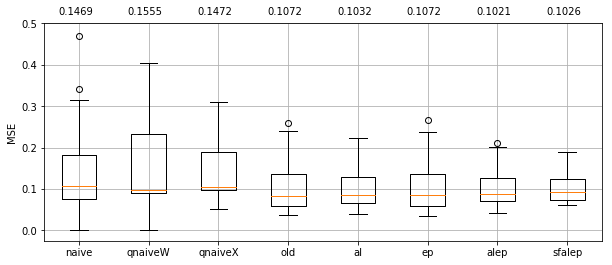

In [31]:
plt.figure(figsize=(10,4))
plt.boxplot(mse.values())
plt.xticks(range(1, len(mse.keys())+1),mse.keys())
for i, txt in enumerate(np.array([np.round(np.mean(v),4) for v in mse.values()]).astype('str')):
    plt.text(i+0.7, np.max(list(mse.values()))+0.05, s=txt)
plt.grid()
plt.ylim([-0.025,.5])
plt.ylabel('MSE')
plt.show()

- nonoise used as a rough estimate of the lowerbound and an ideal model should be able to get as close as possible to this
- naive is used as a reference not to do any worse than that in any of the models
- qnaive comes up with the median quantile of either all training data (X) or only the warm up sequence (W) as the prediction for all the forecasting horizon
- I suspect that the qnaiveX good perforamnce is due to the fact that the mean of the sinusoidal is not changing that much and that's why the performance of the this baseline is relatively good
- 20 splits show a more average case but significance of the uncertainty enabled models is more significant in 10 splits and SFALEP performance is closer to the lower bound
- Although the performance improved using uncertainty over the old model (and variance reduced) but it is not that much obvious here. I suspect this is mainly due to the fact that we are dealing with sinusoidal, should be more significant on other signals
- SFALEP sacrificed the mean performance to less variance

## Study of forecast runtime

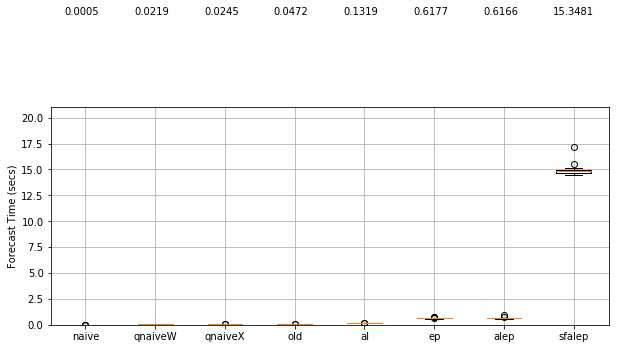

In [32]:
plt.figure(figsize=(10,4))
plt.boxplot(forecast_time.values())
plt.xticks(range(1, len(forecast_time.keys())+1),forecast_time.keys())
for i, txt in enumerate(np.array([np.round(np.mean(v),4) for v in forecast_time.values()]).astype('str')):
    plt.text(i+0.7, np.max(list(forecast_time.values()))+7, s=txt)
plt.grid()
plt.ylabel('Forecast Time (secs)')
plt.ylim([-0.025,21])
plt.show()

- runtime of sfalep increases exonentially with the number of monte carlo simulations as well as scenario forecasts
- currently scenario forecasts are increased exponentially at each time lead with the branching factor of 3 so it will grow with $3^h$, where h is the horizon size. And each scenario forecast is being run $T$ times, T being the number of monte carlo simulations, meaning that the total runtime would be of growth $O(T\times3^h)$ 
- in principle this runtime at test time could be reduced by the factor of $T$
- scenario forecasting is a sequential process and could not be parallelized
- for now the maximum scenarios kept at each time lead is clipped to 10 to make the computations possible. e.g. the number of scenarios would grow as this: 3, 9, 10, 10, 10, 10. (total of 6 time step in the horizon)
- currently parallelization has some difficulties with tensorflow session (need more investigation to get it done!)

## Study of MSE, NMAE, NCRPS

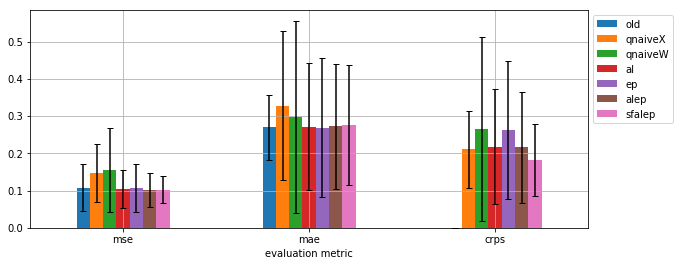

In [33]:
import pandas as pd

methods_to_look_at = ['old', 'qnaiveX', 'qnaiveW', 'al', 'ep', 'alep', 'sfalep']
measurements = []
for i, m in enumerate(methods_to_look_at):
    measurements.append([str(i)+m, '0mse', np.mean(mse[m]), np.std(mse[m])])
    measurements.append([str(i)+m, '1mae', np.mean(nmae[m]), np.std(nmae[m])])
    measurements.append([str(i)+m, '2crps', np.mean(ncrps[m]), np.std(ncrps[m])])
    #measure_std[m] = [np.std(ncrps[m]), np.std(nmae[m]), np.std(mse[m])]
#
df = pd.DataFrame(measurements, columns=['methods','evaluation metric','val','std'])
errors = df.pivot('evaluation metric','methods','std').values.T
df.pivot('evaluation metric','methods','val').plot(kind='bar', yerr=errors, figsize=(10,4), capsize=3, rot=0).legend(methods_to_look_at, bbox_to_anchor=(1, 1))
plt.xticks(range(3), ['mse', 'mae', 'crps'])
plt.grid()
plt.show()

- Although the mean performance of SFALEP not better than ALEP (but almost the same) but it reduced the variance

In [43]:
print(np.round(df.pivot('methods','evaluation metric','val').loc[:,],3))

evaluation metric   0mse   1mae  2crps
methods                               
0old               0.107  0.270  0.000
1qnaiveX           0.147  0.327  0.211
2qnaiveW           0.156  0.298  0.266
3al                0.103  0.272  0.218
4ep                0.107  0.269  0.263
5alep              0.102  0.272  0.217
6sfalep            0.103  0.277  0.183


In [44]:
print(np.round(df.pivot('methods','evaluation metric','std').loc[:,],3))

evaluation metric   0mse   1mae  2crps
methods                               
0old               0.063  0.086  0.000
1qnaiveX           0.079  0.200  0.103
2qnaiveW           0.114  0.258  0.246
3al                0.051  0.171  0.155
4ep                0.064  0.186  0.186
5alep              0.046  0.167  0.150
6sfalep            0.037  0.161  0.097


## NCRPS and NMAE (Lead time view)

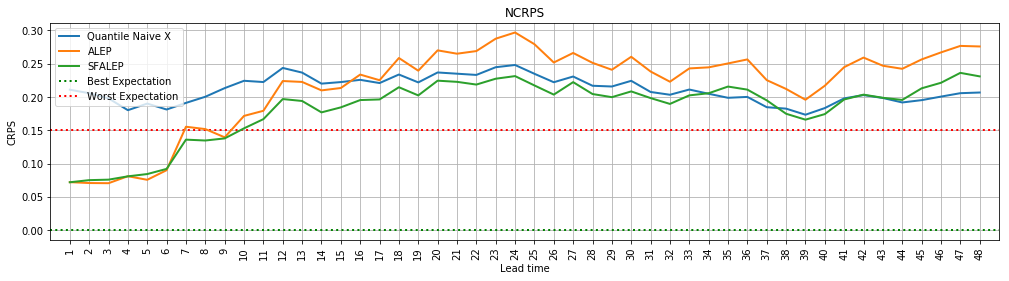

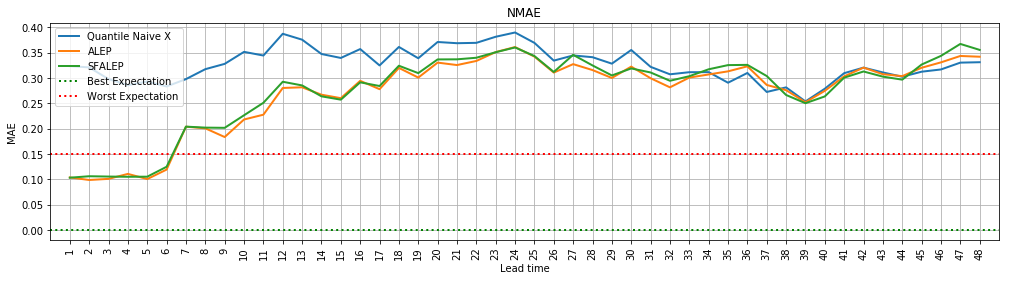

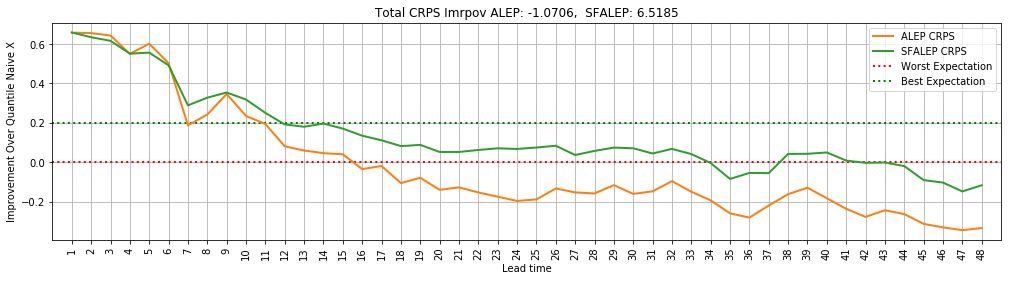

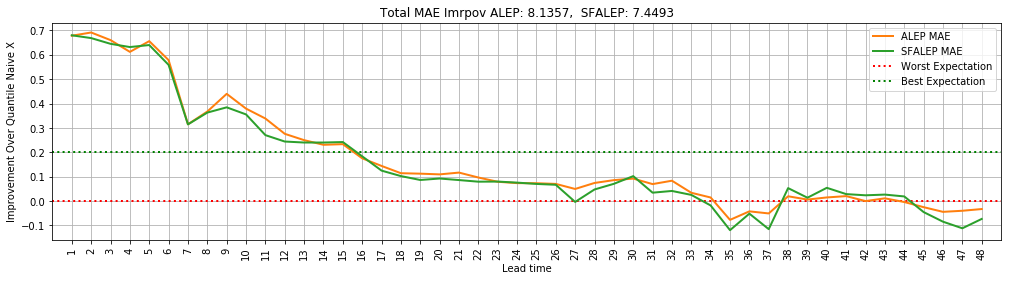

In [36]:
ncrps_qnaiveX = np.mean(np.array(ncrps['qnaiveX']), axis=0)
nmae_qnaiveX = np.mean(np.array(nmae['qnaiveX']), axis=0)
# plot_evaluation(ncrps_qnaiveX, nmae_qnaiveX, period=horizon, title='Quantile Naive X')

ncrps_qnaiveW = np.mean(np.array(ncrps['qnaiveW']), axis=0)
nmae_qnaiveW = np.mean(np.array(nmae['qnaiveW']), axis=0)
# plot_evaluation(ncrps_qnaiveW, nmae_qnaiveW, period=horizon, title='Quantile Naive W')

ncrps_alep = np.mean(np.array(ncrps['alep']), axis=0)
nmae_alep = np.mean(np.array(nmae['alep']), axis=0)
ncrps_alep_improv = improvement(ncrps_qnaiveX, ncrps_alep)
nmae_alep_improv = improvement(nmae_qnaiveX, nmae_alep)
# plot_evaluation(ncrps_alep, nmae_alep, period=horizon, title='Model Aleatoric+Epistemic ')

ncrps_sfalep = np.mean(np.array(ncrps['sfalep']), axis=0)
nmae_sfalep = np.mean(np.array(nmae['sfalep']), axis=0)
ncrps_sfalep_improv = improvement(ncrps_qnaiveX, ncrps_sfalep)
nmae_sfalep_improv = improvement(nmae_qnaiveX, nmae_sfalep)
# plot_evaluation(ncrps_alep, nmae_alep, period=horizon, title='Model Aleatoric+Epistemic with Scenario Forecasting')

%matplotlib inline
plt.figure(figsize=(17,4))
plt.subplot(1,1,1)
plt.plot(ncrps_qnaiveX[0,::], linewidth='2', label='Quantile Naive X', color='C0')
plt.plot(ncrps_alep[0,::], linewidth='2', label='ALEP', color='C1')
plt.plot(ncrps_sfalep[0,::], linewidth='2', label='SFALEP', color='C2')
plt.hlines(0, -1, horizon, color='g', linestyles=':', linewidth=2, label='Best Expectation')
plt.hlines(0.15, -1, horizon, color='r', linestyles=':', linewidth=2, label='Worst Expectation')
plt.xticks(range(horizon), range(1,horizon+1), rotation=90)
plt.xlim([-1,horizon])
plt.grid()
plt.legend(loc='upper left')
plt.xlabel('Lead time')
plt.ylabel('CRPS')
plt.title('NCRPS')
plt.show()
#
plt.figure(figsize=(17,4))
plt.subplot(1,1,1)
plt.plot(nmae_qnaiveX[0,::], linewidth='2', label='Quantile Naive X', color='C0')
plt.plot(nmae_alep[0,::], linewidth='2', label='ALEP', color='C1')
plt.plot(nmae_sfalep[0,::], linewidth='2', label='SFALEP', color='C2')
plt.hlines(0, -1, horizon, color='g', linestyles=':', linewidth=2, label='Best Expectation')
plt.hlines(0.15, -1, horizon, color='r', linestyles=':', linewidth=2, label='Worst Expectation')
plt.xticks(range(horizon), range(1,horizon+1), rotation=90)
plt.xlim([1,horizon+1])
plt.grid()
plt.legend(loc='upper left')
plt.xlabel('Lead time')
plt.ylabel('MAE')
plt.title('NMAE')
plt.xlim([-1,horizon])
plt.show()

plt.figure(figsize=(17,4))
plt.subplot(1,1,1)
plt.plot(ncrps_alep_improv[0,::], linewidth='2', label='ALEP CRPS', color='C1')
plt.plot(ncrps_sfalep_improv[0,::], linewidth='2', label='SFALEP CRPS', color='C2')
plt.hlines(0, -1, horizon, color='r', linestyles=':', linewidth=2, label='Worst Expectation')
plt.hlines(0.2, -1, horizon, color='g', linestyles=':', linewidth=2, label='Best Expectation')
plt.xticks(range(horizon), range(1,horizon+1), rotation=90)
plt.xlabel('Lead time')
plt.ylabel('Improvement Over Quantile Naive X')
plt.title('Total CRPS Imrpov ALEP: %2.4f,  SFALEP: %2.4f' % 
          (np.sum(ncrps_alep_improv), np.sum(ncrps_sfalep_improv)))
plt.grid()
plt.legend()
plt.xlim([-1,horizon])
plt.show()
#
plt.figure(figsize=(17,4))
plt.subplot(1,1,1)
plt.plot(nmae_alep_improv[0,::], linewidth='2', label='ALEP MAE', color='C1')
plt.plot(nmae_sfalep_improv[0,::], linewidth='2', label='SFALEP MAE', color='C2')
plt.hlines(0, -1, horizon, color='r', linestyles=':', linewidth=2, label='Worst Expectation')
plt.hlines(0.2, -1, horizon, color='g', linestyles=':', linewidth=2, label='Best Expectation')
plt.xticks(range(horizon), range(1,horizon+1), rotation=90)
plt.xlabel('Lead time')
plt.ylabel('Improvement Over Quantile Naive X')
plt.title('Total MAE Imrpov ALEP: %2.4f,  SFALEP: %2.4f' % 
          (np.sum(nmae_alep_improv), np.sum(nmae_sfalep_improv)))
plt.grid()
plt.legend()
plt.xlim([-1,horizon])
plt.show()

- performance loose in long horizon could be seen (with relatively considerable slope, this also contributed by the fact that we have irregular sampling of the sinusoidal signal)
- perhaps in 3 days ahead prediction performance of the best models gets worse than naive (this doesn't say much about the model since the signal is sinusoidal and naive is very optimistic baseline for the sinusoidal)
- SFALEP improves quality of the quantiles by sacrificing a bit over the median (actually mean could also be tried too)
- in the first few hours perhaps SFALEP wouldn't be much of a different from ALEP but in longer run "perhaps" becomes more worth while (yet current results wouldn't show how significant it would be.

## Calibration 

qnaiveX


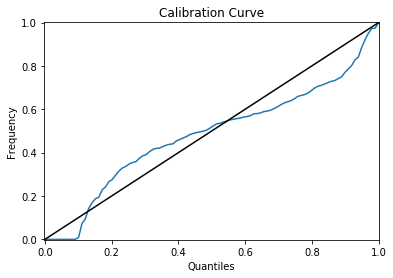

al


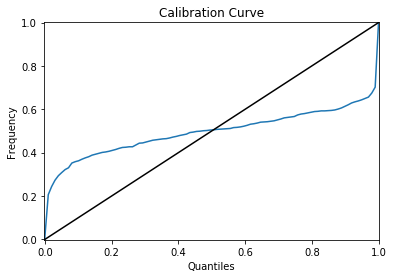

ep


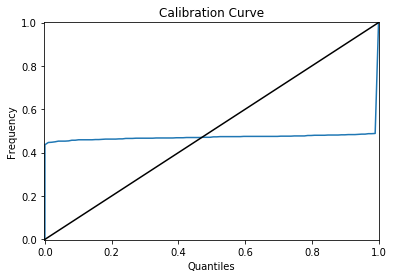

alep


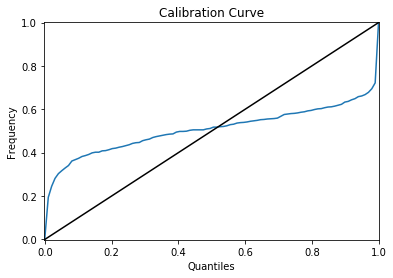

sfalep


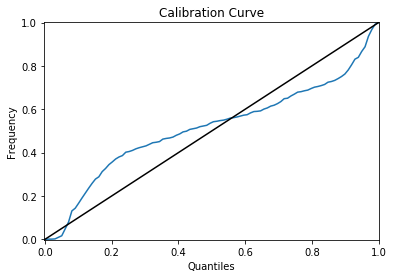

In [37]:
# forecasts['sfalep']
methods_to_plot = ['qnaiveX', 'al', 'ep', 'alep', 'sfalep']
for m in methods_to_plot:
    print(m)
    plot_calibration_curve_multiple_measurements(forecasts[m], y_real, debug=True)

### Calibration of QNaiveX vs QNaiveW

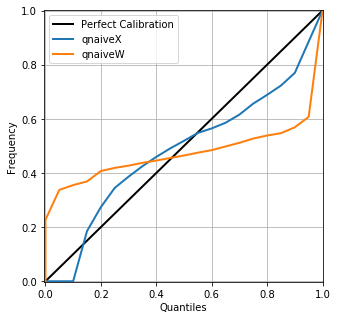

In [38]:
from calibration_curves import *

plt.figure(figsize=(5,5))
ax = plt.subplot(111)
nr_quantiles = 21
quantiles = np.linspace(0, 1, nr_quantiles)
ax.plot(quantiles, quantiles, label='Perfect Calibration', color='k', linewidth=2)
for m in ['qnaiveX', 'qnaiveW']:
    plot_calibration_curve_multiple_measurements_withax(forecasts[m], y_real, name=m,
                                                        nr_quantiles=nr_quantiles, debug=False, ax=ax)
plt.grid()
plt.show()

### Calibration of all together

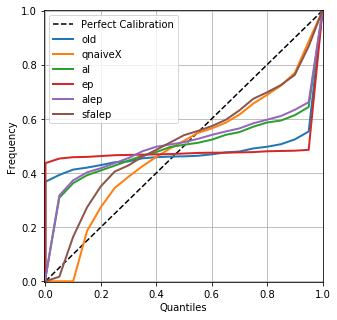

In [39]:
from calibration_curves import *

plt.figure(figsize=(5,5))
ax = plt.subplot(111)
nr_quantiles = 21
quantiles = np.linspace(0, 1, nr_quantiles)
ax.plot(quantiles, quantiles, label='Perfect Calibration', color='k', linestyle='--', linewidth=1.5)
for m in ['old', 'qnaiveX', 'al', 'ep', 'alep', 'sfalep']:
    if m == 'old':
        plot_calibration_curve_multiple_measurements_pointestimates(forecasts['old'], y_real, name='old', ax=ax)
    else:
        plot_calibration_curve_multiple_measurements_withax(forecasts[m], y_real, name=m,
                                                        nr_quantiles=nr_quantiles, debug=False, ax=ax)
plt.grid()
plt.show()

- The above curve obtained by looking at the frequency of the true value lying inside the given quantile of the predictive distribution.
- although each lead time (predicted variable in horizon) is different from the other but to calculate the predictive distribution all treated to be same. (this assumption is not all correct since there is a temporal dependency between variables)
- Since we are interested in the calibration of the model in general we sample from predictive distribution of all variables in the horizon and that is assumed to be approximately normally distirbution (if variables are independdent, but they are not) so the resulting calibration curve is not all correct!
- That is why perhaps we need to use residuals where it is ought to be decorrelated and independent
- <strike>Why we have significant miscalibration (overconfidence in low and high confidence levels?)</strike>
- <strike> Except those confidence levels, for the rest part it seems that SFALEP improves ALEP, ALEP improves both of AL and EP. In general all models are an improvement over quantile naive </strike>

### Calibration of QNaiveX, QNaiveW vs SFALEP

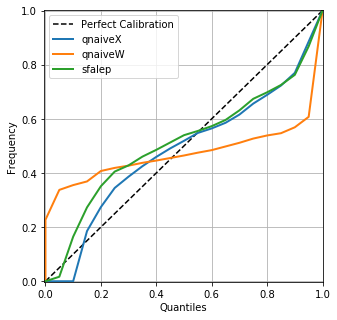

In [40]:
from calibration_curves import *

plt.figure(figsize=(5,5))
ax = plt.subplot(111)
nr_quantiles = 21
quantiles = np.linspace(0, 1, nr_quantiles)
ax.plot(quantiles, quantiles, label='Perfect Calibration', color='k', linewidth=1.5, linestyle='--')
for m in ['qnaiveX', 'qnaiveW', 'sfalep']:
    plot_calibration_curve_multiple_measurements_withax(forecasts[m], y_real, name=m,
                                                        nr_quantiles=nr_quantiles, debug=False, ax=ax)
plt.grid()
plt.show()

### Calibration of old, AL, EP, ALEP, and SFALEP

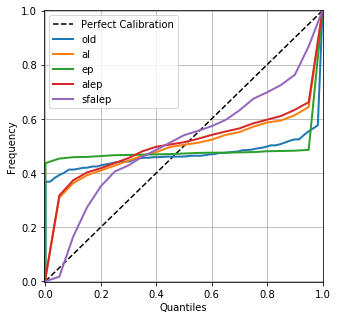

In [41]:
from calibration_curves import *

plt.figure(figsize=(5,5))
ax = plt.subplot(111)
quantiles = np.linspace(0, 1, nr_quantiles)
ax.plot(quantiles, quantiles, color='k', linestyle='--', label='Perfect Calibration', linewidth=1.5)
for m in ['old', 'al', 'ep', 'alep', 'sfalep']:
    if m == 'old':
        plot_calibration_curve_multiple_measurements_pointestimates(forecasts['old'], y_real, nr_quantiles=60, name='old', ax=ax)
    else:
        plot_calibration_curve_multiple_measurements_withax(forecasts[m], y_real, name=m,
                                                        nr_quantiles=nr_quantiles, debug=False, ax=ax)
plt.grid()
plt.show()

- It seems that the SFALEP is overconfidence in general while naive underconfidence (except those low and high confidence level cases)

# Final Forecasts on Test

48


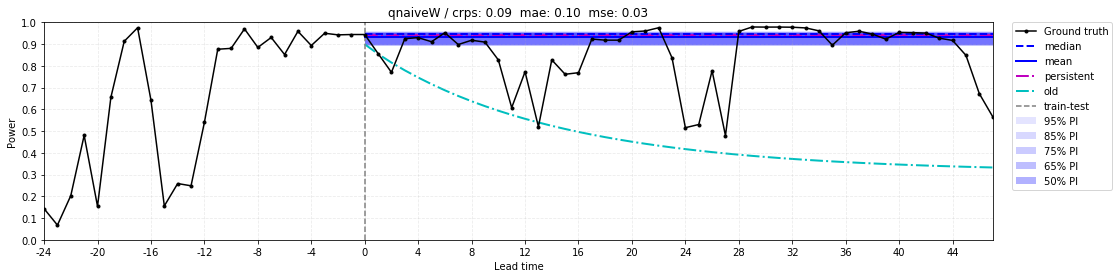

48


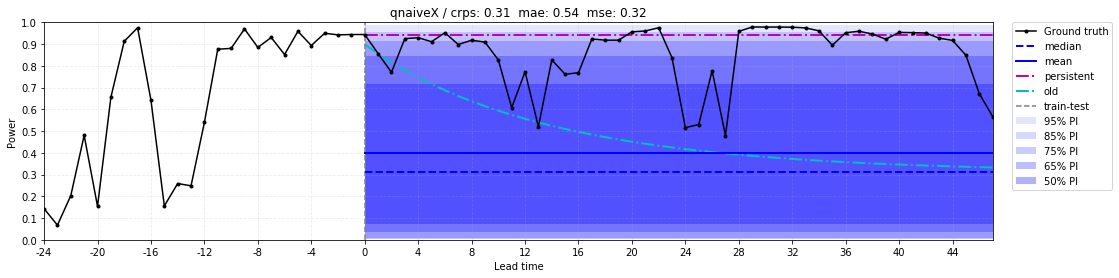

48


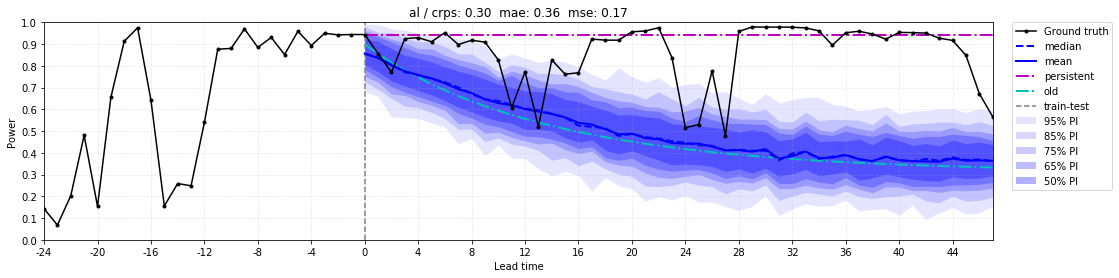

48


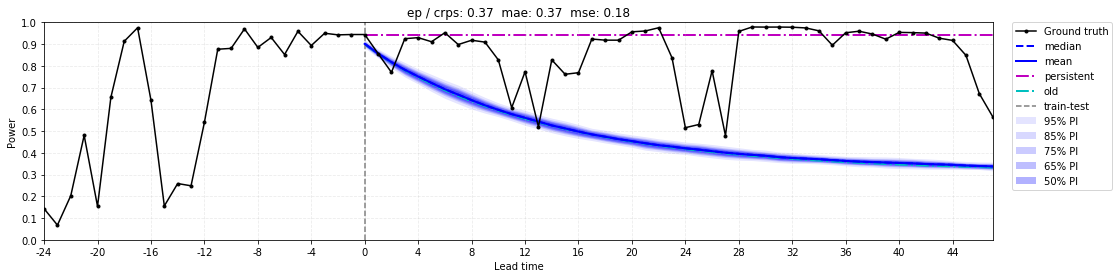

48


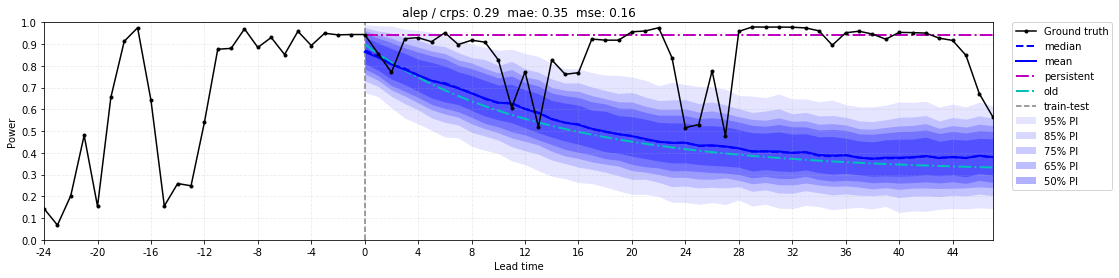

48


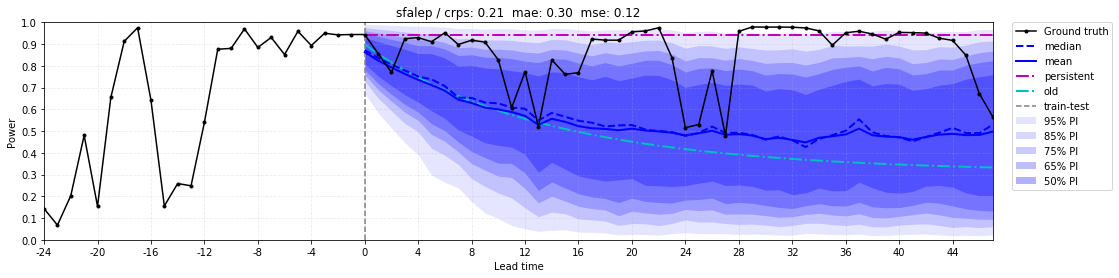

In [42]:
class Test:
    def __init__(self):
        tscv = TimeSeriesSplit(n_splits=n_splits)
        self.methods = ['naive', 'qnaiveW', 'qnaiveX', 'old', 'al', 'ep', 'alep', 'sfalep']
        self.mse = {m:[] for m in methods}
        self.nmae = {m:[] for m in methods}
        self.ncrps = {m:[] for m in methods}
        self.forecasts = {m:[] for m in methods}
        self.forecast_time = {m:[] for m in methods}  
        
    def run(self, horizon=48, n_sims=20):
        pbar = tqdm(total=len(self.methods))
        self.X = test_warmup #samples_normalized[-(n_input+test_size):][:n_input]
        self.y = test[:horizon,:]
        self.horizon = horizon
        
        # naive
        start = time.time()
        naive = Naive()
        y_naive = naive.forecast(warmup=self.X[-n_input:,0], test=self.y[:,0])
        assert len(y_naive) == len(self.y)
        self.forecasts['naive'].append(y_naive)
        self.mse['naive'].append(mean_squared_error(self.y[:,0], y_naive))
        self.forecast_time['naive'].append(time.time()-start)
        pbar.update(1)

        # quantile naive with X
        start = time.time()
        quantileNaive = QuantileNaive(horizon=horizon, forecast_with_warmup=False)
        quantileNaive.fit(X, y)
        y_qnaiveX = quantileNaive.forecast_probabilistic(warmup=self.X[-n_input:,0], test=self.y[:,0])
        #     assert len(y_qnaiveX) == len(self.y)
        self.forecasts['qnaiveX'].append(y_qnaiveX)
        self.mse['qnaiveX'].append(mean_squared_error(self.y[:,0], y_qnaiveX.median()))
        ncrps_qnaiveX, nmae_qnaiveX = evaluate(self.y[:,0], [y_qnaiveX], period=horizon)
        self.nmae['qnaiveX'].append(nmae_qnaiveX)
        self.ncrps['qnaiveX'].append(ncrps_qnaiveX)
        self.forecast_time['qnaiveX'].append(time.time()-start)
        pbar.update(1)

        # quantile naive with Warmup
        start = time.time()
        quantileNaive = QuantileNaive(horizon=horizon, forecast_with_warmup=True)
        y_qnaiveW = quantileNaive.forecast_probabilistic(warmup=self.X[-n_input:,0], test=self.y[:,0])
        #assert len(y_qnaiveW.foreca) == len(self.y)
        self.forecasts['qnaiveW'].append(y_qnaiveW)
        self.mse['qnaiveW'].append(mean_squared_error(self.y[:,0], y_qnaiveW.median()))
        ncrps_qnaiveW, nmae_qnaiveW = evaluate(self.y[:,0], [y_qnaiveW], period=horizon)
        self.nmae['qnaiveW'].append(nmae_qnaiveW)
        self.ncrps['qnaiveW'].append(ncrps_qnaiveW)
        self.forecast_time['qnaiveW'].append(time.time()-start)
        pbar.update(1)

        # old model
        start = time.time()
        y_old = modelOld.forecast(warmup=self.X[-n_input:], test=self.y)
        assert len(y_old) == len(self.y)
        self.forecasts['old'].append(y_old)
        self.mse['old'].append(mean_squared_error(self.y[:,0], y_old))
        self.forecast_time['old'].append(time.time()-start)
        pbar.update(1)

        # aleatoric (AL)
        start = time.time()
        y_al = modelAleatoric.forecast(warmup=self.X[-n_input:], test=self.y)
        assert len(y_al.median()) == len(self.y)
        self.forecasts['al'].append(y_al)
        self.mse['al'].append(mean_squared_error(self.y[:,0], y_al.median()))
        ncrps_al, nmae_al = evaluate(self.y[:,0], [y_al], period=horizon)
        self.nmae['al'].append(nmae_al)
        self.ncrps['al'].append(ncrps_al)
        self.forecast_time['al'].append(time.time()-start)
        pbar.update(1)

        # epistemic (EP)
        start = time.time()
        y_ep = modelEpistemic.forecast(warmup=self.X[-n_input:], test=self.y, nc_simulation=n_sims)
        assert len(y_ep.median()) == len(self.y)
        self.forecasts['ep'].append(y_ep)
        self.mse['ep'].append(mean_squared_error(self.y[:,0], y_ep.median()))    
        ncrps_ep, nmae_ep = evaluate(self.y[:,0], [y_ep], period=horizon)
        self.nmae['ep'].append(nmae_ep)
        self.ncrps['ep'].append(ncrps_ep)
        self.forecast_time['ep'].append(time.time()-start)
        pbar.update(1)
        
        # AL+EP
        start = time.time()
        y_alep = modelAleatoricEpistemic.forecast(warmup=self.X[-n_input:], test=self.y)
        assert len(y_alep.median()) == len(self.y)
        self.forecasts['alep'].append(y_alep)
        self.mse['alep'].append(mean_squared_error(self.y[:,0], y_alep.median()))
        ncrps_alep, nmae_alep = evaluate(self.y[:,0], [y_alep], period=horizon)
        self.nmae['alep'].append(nmae_alep)
        self.ncrps['alep'].append(ncrps_alep)
        self.forecast_time['alep'].append(time.time()-start)
        pbar.update(1)

        # Scenario Forecasting (SF) + ALEP
        start = time.time()
        y_sfalep = modelAleatoricEpistemic.scenario_forecast(test_warmup=self.X[-n_input:], test=self.y, horizon=horizon, n_sims=n_sims)
        assert len(y_sfalep.median()) == len(self.y)
        self.forecasts['sfalep'].append(y_sfalep)
        self.mse['sfalep'].append(mean_squared_error(self.y[:,0], y_sfalep.median()))
        ncrps_sfalep, nmae_sfalep = evaluate(self.y[:,0], [y_sfalep], period=horizon)
        self.nmae['sfalep'].append(nmae_sfalep)
        self.ncrps['sfalep'].append(ncrps_sfalep)
        self.forecast_time['sfalep'].append(time.time()-start)
        pbar.update(1)
        
    def plot_forecast_time(self):
        plt.figure(figsize=(10,3))
        plt.boxplot(self.forecast_time.values())
        plt.xticks(range(1, len(self.forecast_time.keys())+1),self.forecast_time.keys())
        for i, txt in enumerate(np.array([np.round(np.mean(v),4) for v in self.forecast_time.values()]).astype('str')):
            plt.text(i+0.7, np.max(list(self.forecast_time.values()))+0.5, s=txt)
        plt.grid()
        plt.ylabel('Forecast Time (secs)')
        plt.show()
        
    def plot_forecast_mse(self):
        plt.figure(figsize=(10,7))
        plt.boxplot(self.mse.values())
        plt.xticks(range(1, len(self.mse.keys())+1),self.mse.keys())
        for i, txt in enumerate(np.array([np.round(np.mean(v),4) for v in self.mse.values()]).astype('str')):
            plt.text(i+0.7, np.max(list(self.mse.values()))+0.025, s=txt)
        plt.grid()
        plt.ylim([-0.025,.43])
        plt.ylabel('MSE')
        plt.show()
        
    def plot_forecasts(self):
        for m in ['qnaiveW', 'qnaiveX', 'al', 'ep', 'alep', 'sfalep']:
            crps = np.mean(self.ncrps[m])
            mae = np.mean(self.nmae[m])
            mse = np.mean(self.mse[m])
            plot_title = "{0} / crps: {1:.2f}  mae: {2:.2f}  mse: {3:.2f}".format(m, crps, mae, mse)
            baselines = {'persistent': naive.forecast(xxx[:,0], self.y[:,0]), 'old': self.forecasts['old'][0]}
            plot_forecast_dense(xxx[:,0], self.y[:,0], self.forecasts[m][0], 
                                horizon=self.horizon, baselines=baselines,
                                alphas=[0.05, 0.15, 0.25, 0.35, 0.5], title=plot_title)
            
        
        
allModelsTest = Test()
allModelsTest.run(horizon=horizon, n_sims=20)
# allModelsTest.plot_forecast_time()
# allModelsTest.plot_forecast_mse()
allModelsTest.plot_forecasts()

# Conclusions/Discussions


- input sequence length 4 is a good balance between computation cost and necessity (also backed by auto-correlation plot)
- results for SFALEP imrpovements on crps are consistent with the sinusoidal experiment
- In long horizons SFALEP is helpful compared with ALEP but in general performance drops especially compared to the qnaivex for longer horizons (consistent with the sinusoidal experiment)
- In short horizons SFALEP and ALEP are not that much different (consistent with sinusoidal experiment)
- All method perform on average better than QNAIVE on MSE while getting worse in longer horizons also with regarding to the variance SFALEP is the best
- Same models with same parameters and configuration from the sinusoidal case used and works here - all stable and learning is positive (saturates but it is possible to make the learning more efficient by parameter tuning and learn more with more data)
- this approach does not have much model complexity cost for scenario forecasting (if current approach for scenario genrations is good enough for the intended application!)


**Issues (Solved)**:

**Issues (Remaining)**:
- why EP is so much miscalibrated? need a discussion
- the forecast is not good on the extremes (around 0 and around 1) due to activation, probably needs separate delta distribution over there.
- it seems that the crps values on the title of the final plots are not correct
- some latest updates needs to be brought from the other notebook to here (for example the scenarios)

**Curiousity/Future steps**:
- calculate calibration based on Yarin's paper freuency of residuals over the predictive distribution (DONE ALREADY!)
- how would the model performance change over different expanding windows (now only applied expanding window for validation, try to do it also for fitting) (For current research and experiments not important, current approach is sufficient for strong and valid conclusions!)
- performance using MLP on multivariate case GEEFCOM
- performance on GEFCOM'14 (ALREADY ON IT! :D)
  - (some initial experiments failed but without wind speed, incorporate wind (SUCCESS, DONE!)
  -  also my previous experiments were disapointing with discrete and continuos cases so I am thinking about running a super simple model for crazy amounts of epochs (yet to stable the train-validation loss minimization, I think I had an setup that could reduce this for quite a long time) and then see if power NN as function approximation comes true or not. (THIS CASE STILL NEEDS EXPLORING FOR THE FUTURE!)
  - if that didn't help then I am thinking about selectiev learning (train model only on portions that are similar to the warmup sequence (recent history))
  
- loss function (crps - I am thinking about a future work on obective function as well as the variational bayesian network approximation)
- model the extremes separately!)
- better handling of the model ignorance, accept distribution as input instead of single points (then it can be handled!)
- engineering: 
  - mcdo parallelization for boost in speed